<a href="https://colab.research.google.com/github/Paewynn/02456-DEEP-LEARNING-s212634/blob/main/Deep_Learning_Project_Final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from sklearn.linear_model import ElasticNet
import numpy as np
import seaborn as sns
from sklearn import metrics

## Pour ignorer les erreurs de convergence
# from sklearn.utils.testing import ignore_warnings
# from sklearn.exceptions import ConvergenceWarning

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import Data

In [ ]:
y = pd.read_csv('Data/Target_Data.csv', index_col = 'Unnamed: 0')
X = pd.read_csv('Data/Wind_Data.csv', index_col = 'Unnamed: 0')

In [6]:
# y = pd.read_csv('/content/gdrive/MyDrive/Deep Learning/Data/Target_Data.csv', index_col = 'Unnamed: 0')
# X = pd.read_csv('/content/gdrive/MyDrive/Deep Learning/Data/Wind_Data.csv', index_col = 'Unnamed: 0')


Data information : 

 - For the training data, each line corresponds to all the wind data of each considered station between a time t and a time t - 24h. Knowing that 178 stations have been selected and that the time step is hourly, there are 178*24 = 4272 features for each example. 
 - For the labels to be predicted, each line corresponds to the load factor between time t + 1h and time t + 4h, i.e. 4 values to predict.


In [7]:
def split(X, y, val_size = 0.1, test_size = 0.2):
    
    m = X.shape[0] ## nombre d'exemples
    indice_bas_test = int(m*(1 - test_size))
    indice_haut_test = int(m)

    X_train_val = X[:indice_bas_test]
    y_train_val = y[:indice_bas_test]
    X_test = X[indice_bas_test:indice_haut_test]
    y_test = y[indice_bas_test:indice_haut_test]

    m_train_val = X_train_val.shape[0]
    indice_bas_val = int(m_train_val*(1 - val_size))
    indice_haut_val = int(m_train_val)

    X_train = X_train_val[:indice_bas_val]
    y_train = y_train_val[:indice_bas_val]
    X_val = X_train_val[indice_bas_val:indice_haut_val]
    y_val = y_train_val[indice_bas_val:indice_haut_val]

    return [X_train_val, X_train, X_val, X_test, y_train_val, y_train , y_val, y_test]
    
X_train_val, X_train, X_val, X_test, y_train_val, y_train , y_val, y_test = split(X, y)

In [8]:
print('X_train_val shape : ',X_train_val.shape)
print('X_train shape : ',X_train.shape)
print('X_val shape : ',X_val.shape)
print('X_test shape : ',X_test.shape)
print('y_train_val shape : ',y_train_val.shape)
print('y_train shape : ',y_train.shape)
print('y_val shape : ',y_val.shape)
print('y_test shape : ',y_test.shape)

X_train_val shape :  (4068, 4272)
X_train shape :  (3661, 4272)
X_val shape :  (407, 4272)
X_test shape :  (1017, 4272)
y_train_val shape :  (4068, 4)
y_train shape :  (3661, 4)
y_val shape :  (407, 4)
y_test shape :  (1017, 4)


### Evaluation



In [9]:

def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def model_evaluate(model, X, y):

  y_pred = model.predict(X)
  y_array = y.values

  y_true_ravel = np.ravel(y_array)
  y_pred_ravel = np.ravel(y_pred)

  print(y_true_ravel)
  print(y_pred_ravel)

  biais_array = y_pred_ravel - y_true_ravel

  ecart_relatif = (abs(y_pred_ravel - y_true_ravel) / y_true_ravel)*100
  sns.set(rc={'figure.figsize':(12,4)})

  print(f'Variance Score = {metrics.explained_variance_score(y_true_ravel, y_pred_ravel)}')
  print(f'Bias Mean = {biais_array.mean()}')
  print(f'r2 score = {metrics.r2_score(y_true_ravel, y_pred_ravel)}')
  print(f'RMSE score = {metrics.mean_squared_error(y_true_ravel, y_pred_ravel)}')

  print(f'Mean Absolute Percentage Error = {mean_absolute_percentage_error(y_true_ravel, y_pred_ravel)}')
  sns.histplot(x = biais_array, kde = True)
  sns.jointplot(x=y_pred_ravel, y=y_true_ravel, kind="reg", color="#4CB391", height = 12)

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Dropout,SimpleRNN,LSTM, GRU, Bidirectional
from keras.models import Sequential
from sklearn.metrics import r2_score
from keras import optimizers
from tensorflow.keras import layers

In [11]:
def training(X, y, batch_size, epochs, modele, name, loss, optimizer, checkpoint = True, tensorboard = True):

  modele.compile(
      loss = loss,
      optimizer = optimizer
  )

  if tensorboard:
    log_fit = 'Results/logs/fit' +'/'+ name
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_fit, histogram_freq=1)
  
  dir_model_h5 = 'Results/'+name+'.h5'

  if checkpoint:
    checkpoint_cb = keras.callbacks.ModelCheckpoint(dir_model_h5, save_best_only=True)

  history = modele.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint_cb,tensorboard_cb])

  return [history, dir_model_h5]


In [12]:
def model_evaluateb(model, X, y):

  y_pred = model.predict(X)
  y_array = y.values

  y_true_ravel = np.ravel(y_array)
  y_pred_ravel = np.ravel(y_pred)

  print(y_true_ravel)
  print(y_pred_ravel)

  biais_array = y_pred_ravel - y_true_ravel

  ecart_relatif = (abs(y_pred_ravel - y_true_ravel) / y_true_ravel)*100
  sns.set(rc={'figure.figsize':(12,4)})

  print(f'Variance Score = {metrics.explained_variance_score(y_true_ravel, y_pred_ravel)}')
  print(f'Moyenne des biais = {biais_array.mean()}')
  print(f'r2 score = {metrics.r2_score(y_true_ravel, y_pred_ravel)}')
  print(f'RMSE score = {metrics.mean_squared_error(y_true_ravel, y_pred_ravel)}')

  print(f'Mean Absolute Percentage Error = {mean_absolute_percentage_error(y_true_ravel, y_pred_ravel)}')
  sns.histplot(x = biais_array, kde = True)
  sns.jointplot(x=y_pred_ravel, y=y_true_ravel, kind="reg", color="#4CB391", height = 12)

# Best performing models for each category of the Poster Session

## Type 1


Model: "model_EDF_1024_512_256_128_64_32_16_8_True_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 1024)              4375552   
                                                                 
 dropout_23 (Dropout)        (None, 1024)              0         
                                                                 
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense

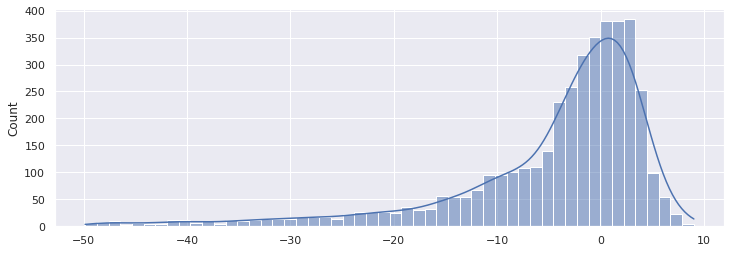

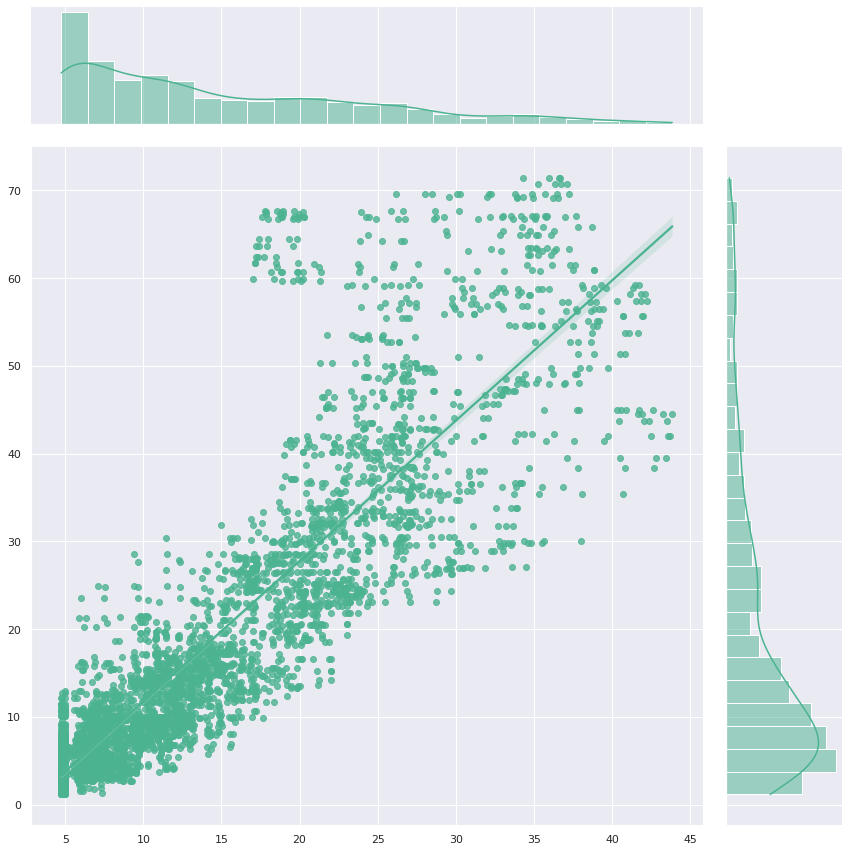

In [ ]:
def create_model(inputs_shape, outputs_shape, hidden_shape, activation ='relu', kernel_initializer = 'he_normal',dropout = True, dropout_rate = 0.01):
    
    name = 'model_EDF_' + str(hidden_shape[0]) + '_'
    
    for index in range(1, len(hidden_shape)):
      name = name + str(hidden_shape[index])+ '_'
    
    name = name + str(dropout) + '_dropout'

    model = keras.Sequential(name = name)

    model.add(layers.Input(shape = (inputs_shape,)))

    for l in range(len(hidden_shape)):
      model.add(layers.Dense(units = hidden_shape[l], activation = activation, kernel_initializer = kernel_initializer))
      if dropout:
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(units = outputs_shape))

    model.summary()

    return [model, name]



model_type_1, name = create_model(inputs_shape = 4272, 
                           outputs_shape = 4, 
                           hidden_shape = (1024, 512, 256, 128, 64, 32,16,8), 
                           dropout = True,
                           dropout_rate= 0.05)

version = input('Version Name :')
loss = keras.losses.MSE
optimizer = keras.optimizers.RMSprop()

history, dir_model_h5 = training(X_train, y_train, 
                                 batch_size = 8, 
                                 epochs = 55, 
                                 modele = model_type_1, 
                                 name = name + '_' + version, 
                                 loss = loss,
                                 optimizer = optimizer)


model_evaluate(model_type_1, X_test, y_test)

32/32 [==============================] - 2s 27ms/step
[ 9.64 11.36 12.26 ...  3.93  3.78  3.69]
[14.216686  14.225004  14.288277  ...  3.9700332  3.988875   4.18335  ]
Variance Score = 0.6865526329249027
Moyenne des biais = -3.5483062172639332
r2 score = 0.6419145510502351
RMSE score = 101.00045574995741
Mean Absolute Percentage Error = 40.556406008639755


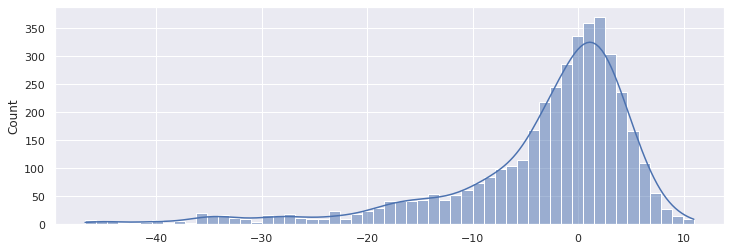

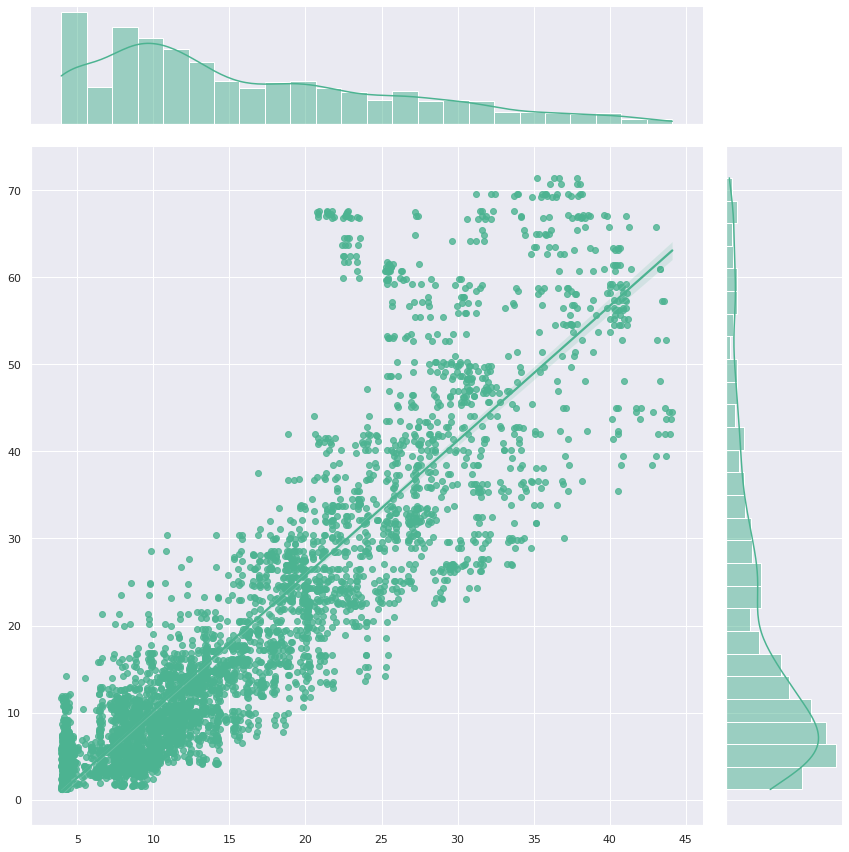

In [ ]:
model_evaluate(model_type_1, X_test, y_test)

## Type 2

In [ ]:


def create_model_conv2(inputs_shape, outputs_shape, hidden_shape, activation ='relu', kernel_initializer = 'he_normal',kernel_siz = 6,dropout = True, dropout_rate = 0.05,max_pool_size = 2):
    
    name = 'model_EDF_' + str(hidden_shape[0]) + '_'
    name += '_conv1d_conv1d_flatten'
    for index in range(1, len(hidden_shape)):
      name = name + str(hidden_shape[index])+ '_'
    
    name = name + str(dropout) + '_dropout'

    model = keras.Sequential(name = name)
    # input_shape = (8, 3661, 4272)
    # model.add(layers.Input(shape = (inputs_shape,)))
    # model.add(layers.Reshape((4272, 1), (3661, 4272)))
    # model.add(layers.Conv1D(filters = 64, kernel_size = 6, activation = 'relu', input_shape = (None,4272, 1)))
    model.add(layers.Conv1D(filters=32, kernel_size=kernel_siz, activation='relu', input_shape=(X_train_2.shape[1], X_train_2.shape[2])))
    model.add(layers.MaxPooling1D(pool_size = 2))
    model.add(layers.Conv1D(filters=32, kernel_size=kernel_siz, activation='relu', input_shape=(X_train_2.shape[1], X_train_2.shape[2])))
    model.add(layers.MaxPooling1D(pool_size = 2))
    # model.add(Conv1D(filters = 64, kernel_size = 3, activation = 'relu'))
    # 
    model.add(layers.Flatten())

    for l in range(len(hidden_shape)):
      model.add(layers.Dense(units = hidden_shape[l], activation = activation, kernel_initializer = kernel_initializer))
      if dropout:
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(units = outputs_shape))

    model.summary()

    return [model, name]




model_conv3, name = create_model_conv2(inputs_shape = 4272, 
                           outputs_shape = 4, 
                           hidden_shape = ( 512, 256, 128, 64, 32, 16, 8), 
                           dropout = True,
                           kernel_siz = 6,
                           dropout_rate= 0.05,
                           max_pool_size = 2)

version = input('Changement effectué si même réseau de neurones ou version si différent : ')
loss = keras.losses.MSE
optimizer = keras.optimizers.RMSprop()

history, dir_model_h5 = training(X_train_3, y_train, 
                                 batch_size = 12, 
                                 epochs = 30, 
                                 modele = model_conv3, 
                                 name = name + '_' + version, 
                                 loss = loss,
                                 optimizer = optimizer)

model_evaluate(model_conv3, X_test_3, y_test)

## Type 3

In [ ]:
def create_model_conv_lstm2(inputs_shape, outputs_shape, hidden_shape, activation ='relu', kernel_initializer = 'he_normal',kernel_siz = 6,dropout = True, dropout_rate = 0.05,max_pool_size = 2):
    
    name = 'model_EDF_' + str(hidden_shape[0]) + '_'
    name += '_conv1d_conv1d_flatten'
    for index in range(1, len(hidden_shape)):
      name = name + str(hidden_shape[index])+ '_'
    
    name = name + str(dropout) + '_dropout'

    model = keras.Sequential(name = name)

    model.add(layers.Conv1D(filters=32, kernel_size=kernel_siz, activation='relu', input_shape=(X_train_2.shape[1], X_train_2.shape[2])))
    model.add(tf.keras.layers.MaxPooling1D(2, padding="same"))
    model.add(layers.Conv1D(filters=32, kernel_size=kernel_siz, activation='relu', input_shape=(X_train_2.shape[1], X_train_2.shape[2])))
    model.add(tf.keras.layers.MaxPooling1D(2, padding="same"))

    model.add(tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True))
    # model.add(tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True))

    model.add(layers.Flatten())

    for l in range(len(hidden_shape)):
      model.add(layers.Dense(units = hidden_shape[l], activation = activation, kernel_initializer = kernel_initializer))
      if dropout:
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(units = outputs_shape))

    model.summary()

    return [model, name]


model_conv_lstm2, name = create_model_conv_lstm2(inputs_shape = 4272, 
                           outputs_shape = 4, 
                           hidden_shape = (  128, 64, 32, 16, 8), 
                           dropout = True,
                           kernel_siz = 6,
                           dropout_rate= 0.1,
                           max_pool_size = 2)

version = input('Changement effectué si même réseau de neurones ou version si différent : ')
loss = keras.losses.MSE
optimizer = keras.optimizers.RMSprop()

history, dir_model_h5 = training(X_train_3, y_train, 
                                 batch_size = 16, 
                                 epochs = 15, 
                                 modele = model_conv_lstm2, 
                                 name = name + '_' + version, 
                                 loss = loss,
                                 optimizer = optimizer)

model_evaluate(model_conv_lstm2, X_test_3, y_test)




# Hour Per Hour Model evalutation

In [16]:
def model_evaluateb(model, X, y):

  # y_pred = model.predict(X)
  # y_array = y.values

  y_true_ravel = np.ravel(y)
  y_pred_ravel = np.ravel(X)
  # y_true_ravel = X
  # y_pred_ravel = y

  print(y_true_ravel)
  print(y_pred_ravel)

  biais_array = y_pred_ravel - y_true_ravel

  ecart_relatif = (abs(y_pred_ravel - y_true_ravel) / y_true_ravel)*100
  sns.set(rc={'figure.figsize':(12,4)})

  print(f'Variance Score = {metrics.explained_variance_score(y_true_ravel, y_pred_ravel)}')
  print(f'Moyenne des biais = {biais_array.mean()}')
  print(f'r2 score = {metrics.r2_score(y_true_ravel, y_pred_ravel)}')
  print(f'RMSE score = {metrics.mean_squared_error(y_true_ravel, y_pred_ravel)}')

  print(f'Mean Absolute Percentage Error = {mean_absolute_percentage_error(y_true_ravel, y_pred_ravel)}')
  sns.histplot(x = biais_array, kde = True)
  graph = sns.jointplot(x=y_pred_ravel, y=y_true_ravel, kind="reg", color="#4CB391", height = 12)
  graph.set_axis_labels('prediction', 'target', fontsize=16)

test = pd.DataFrame.to_numpy(y_test)



In [17]:
from datetime import datetime

# DatetimeIndex: 5133 entries, 2020-03-01 02:00:00 to 2020-09-30 22:00:00
# X_train_3[0,0:24]
# 2020-03-02 01:00:00   ->  3.333 = première date datframe

#datetime(year, month, day)
a = datetime(2018, 11, 28)

# datetime(year, month, day, hour, minute, second, microsecond)
b = datetime(2017, 11, 28, 23, 55, 59, 342380)

y2= pd.DataFrame.to_numpy(y)
# y[:,0]
tamp2 = np.zeros([np.shape(y2)[0],24])

for i in range(24,np.shape(y2)[0]):
  for t in range(24):
    tamp2[i,t]=y2[i-t,0]
tamp2
tamp2 = tamp2.reshape((np.shape(tamp2)[0],np.shape(tamp2)[1],1))
y2= y2[24:]
y2 = pd.DataFrame(y2)

X2=pd.DataFrame.to_numpy(X)

np.shape(X2)
X2 = X2.reshape([np.shape(X2)[0],np.shape(X2)[1],1])
np.shape(X2)



tamp = np.zeros([np.shape(X2)[0],2,1])

for i in range(np.shape(tamp)[0]):
  t=24*61+1 +i
  tamp[i,0] = np.cos(2*np.pi/(366*24)*t)
  tamp[i,1] = np.sin(2*np.pi/(366*24)*t)

X2 = np.hstack((X2,tamp2))
X2=np.hstack((X2,tamp))
X2 = X2[24:]
X_train_val, X_train, X_val, X_test, y_train_val, y_train , y_val, y_test = split(X2, y2)
X_train_2 = X_train #.to_numpy()
X_traint=X_train[:,:178*24]
X_train_3 = X_train[:,:178*24]#.to_numpy().to_numpy()
X_train_3=X_train_3.reshape((int(X_train.shape[0]), 24, int((X_train.shape[1]-26)/24)))

X_train_3=np.transpose(X_train_3, axes=(0,2,1))
X_train_3=X_train_3.reshape((int(X_train.shape[0]),  int((X_train.shape[1]-26)),1))
X_traint=X_train[:,:178*24]
X_train_4 =X_traint
X_train_4=X_train_4.reshape((int(X_train.shape[0]), 24, int((X_train.shape[1]-26)/24)))
X_train_4=np.transpose(X_train_4, axes=(0,2,1))
X_train_4=X_train_4.reshape((int(X_train.shape[0]),  int((X_train.shape[1]-26)),1))
X_train_4 = np.hstack((X_train_4,X_train[:,178*24:]))

X_test_4 = X_test[:,:178*24] #.to_numpy().to_numpy()
X_test_4=X_test_4.reshape((int(X_test.shape[0]), 24, int(X_traint.shape[1]/24)))
X_test_4=np.transpose(X_test_4, axes=(0,2,1))
X_test_4=X_test_4.reshape((int(X_test.shape[0]),  int(X_traint.shape[1]),1))
X_test_4=np.hstack((X_test_4,X_test[:,178*24:]))

X_val_4 = X_val[:,:178*24] #.to_numpy().to_numpy()
X_val_4=X_val_4.reshape((int(X_val_4.shape[0]), 24, int(X_traint.shape[1]/24)))
X_val_4=np.transpose(X_val_4, axes=(0,2,1))
X_val_4=X_val_4.reshape((int(X_val.shape[0]),  int(X_traint.shape[1]),1))
X_val_4=np.hstack((X_val_4,X_val[:,178*24:]))

In [18]:
def training_2(X, y, batch_size, epochs, modele, name, loss, optimizer, checkpoint = True, tensorboard = True):

  modele.compile(
      loss = loss,
      optimizer = optimizer
  )

  if tensorboard:
    log_fit = 'Results/logs/fit' +'/'+ name
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_fit, histogram_freq=1)
  
  dir_model_h5 = 'Results/'+name+'.h5'

  if checkpoint:
    checkpoint_cb = keras.callbacks.ModelCheckpoint(dir_model_h5, save_best_only=True)

  history = modele.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=(X_val_4, y_val), callbacks=[checkpoint_cb,tensorboard_cb])

  return [history, dir_model_h5]

# Parameter Tuning

## Dense model

### Best Dense model
40 min of training


32/32 [==============================] - 0s 15ms/step
[17.54 13.07  9.78 ... 22.84 21.69 18.16]
[12.1071005 12.102192  11.952461  ... 18.138283  17.956879  17.888264 ]
Variance Score = 0.8953594392550057
Moyenne des biais = -3.3692643176273673
r2 score = 0.8552810243411526
RMSE score = 40.990678588298
Mean Absolute Percentage Error = 27.6313614659171


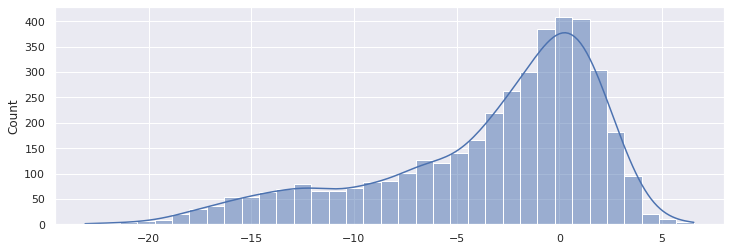

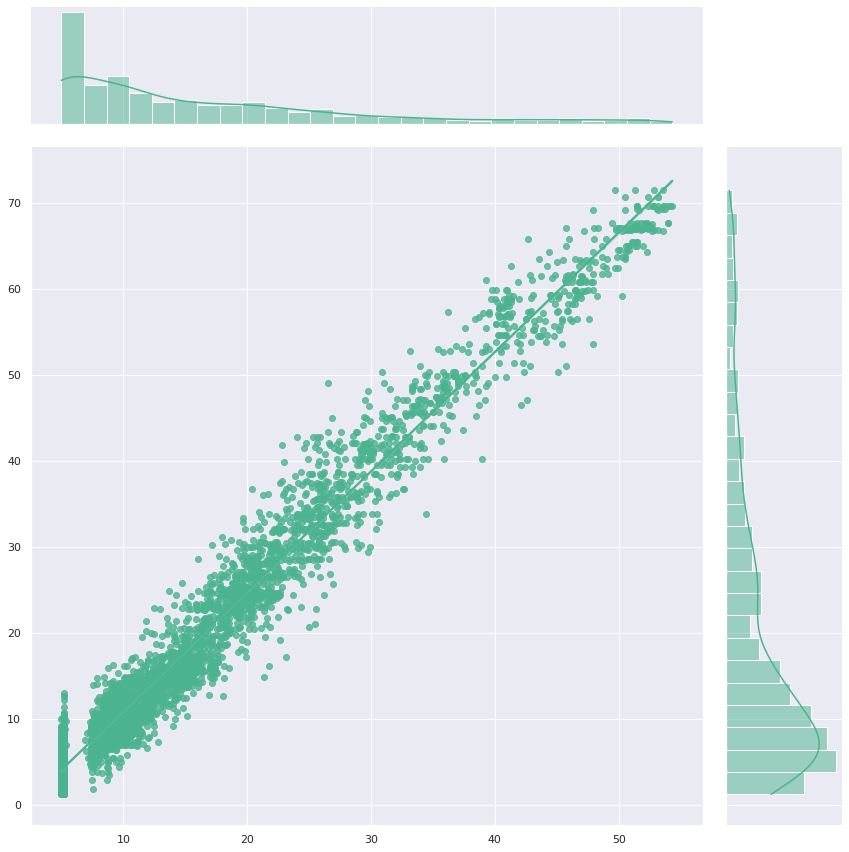

In [ ]:
def create_model(inputs_shape, outputs_shape, hidden_shape, activation ='relu', kernel_initializer = 'he_normal',dropout = True, dropout_rate = 0.01):
    
    name = 'model_EDF_' + str(hidden_shape[0]) + '_'
    
    for index in range(1, len(hidden_shape)):
      name = name + str(hidden_shape[index])+ '_'
    
    name = name + str(dropout) + '_dropout'

    model = keras.Sequential(name = name)

    model.add(layers.Input(shape = (inputs_shape,)))

    model.add(layers.Flatten())
    
    for l in range(len(hidden_shape)):
      model.add(layers.Dense(units = hidden_shape[l], activation = activation, kernel_initializer = kernel_initializer))
      if dropout:
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(units = outputs_shape))

    model.summary()

    return [model, name]



model_type_1_3, name = create_model(inputs_shape = np.shape(X_train_4)[1], 
                           outputs_shape = 4, 
                           hidden_shape = ( 512, 256, 128, 64, 32,16,8), 
                           dropout = True,
                           dropout_rate= 0.05)

# version = input('Version Name :')
version = 'b4_e50'
loss = keras.losses.MSE
optimizer = keras.optimizers.RMSprop()

history, dir_model_h5 = training_2(X_train_4, y_train, 
                                 batch_size = 8, #8 avant
                                 epochs = 50, 
                                 modele = model_type_1_3, 
                                 name = name + '_' + version, 
                                 loss = loss,
                                 optimizer = optimizer)


model_evaluate(model_type_1_3, X_test_4, y_test)



In [ ]:
def create_model(inputs_shape, outputs_shape, hidden_shape, activation ='relu', kernel_initializer = 'he_normal',dropout = True, dropout_rate = 0.01):
    
    name = 'model_EDF_' + str(hidden_shape[0]) + '_'
    
    for index in range(1, len(hidden_shape)):
      name = name + str(hidden_shape[index])+ '_'
    
    name = name + str(dropout) + '_dropout'

    model = keras.Sequential(name = name)

    model.add(layers.Input(shape = (inputs_shape,)))

    model.add(layers.Flatten())
    
    for l in range(len(hidden_shape)):
      model.add(layers.Dense(units = hidden_shape[l], activation = activation, kernel_initializer = kernel_initializer))
      if dropout:
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(units = outputs_shape))

    model.summary()

    return [model, name]



model_type_1_3, name = create_model(inputs_shape = np.shape(X_train_4)[1], 
                           outputs_shape = 4, 
                           hidden_shape = ( 512, 256, 128, 64, 32,16,8), 
                           dropout = True,
                           dropout_rate= 0.05)


Model: "model_EDF_512_256_128_64_32_16_8_True_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4298)              0         
                                                                 
 dense (Dense)               (None, 512)               2201088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout) 

## Convolutionnal Models

### Best convolutionnal model
135 min training

Epoch 1/20
152/152 [==============================] - 93s 609ms/step - loss: 14.1467 - val_loss: 8.0934
Epoch 2/20
152/152 [==============================] - 92s 604ms/step - loss: 13.1017 - val_loss: 8.1806
Epoch 3/20
152/152 [==============================] - 92s 607ms/step - loss: 14.3804 - val_loss: 7.5752
Epoch 4/20
152/152 [==============================] - 96s 630ms/step - loss: 13.9058 - val_loss: 7.5704
Epoch 5/20
152/152 [==============================] - 92s 604ms/step - loss: 14.3716 - val_loss: 8.1386
Epoch 6/20
152/152 [==============================] - 90s 591ms/step - loss: 14.2940 - val_loss: 7.5831
Epoch 7/20
152/152 [==============================] - 100s 659ms/step - loss: 13.3065 - val_loss: 7.0890
Epoch 8/20
152/152 [==============================] - 87s 574ms/step - loss: 14.0922 - val_loss: 7.8213
Epoch 9/20
152/152 [==============================] - 88s 577ms/step - loss: 13.8716 - val_loss: 8.3291
Epoch 10/20
152/152 [==============================] - 89s 586m

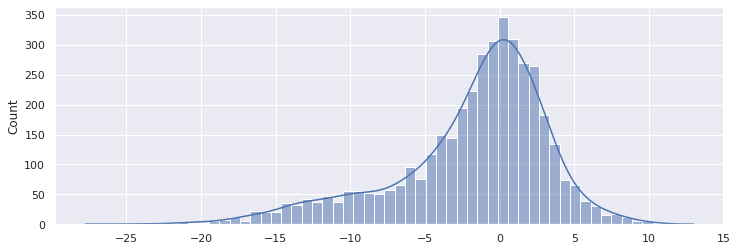

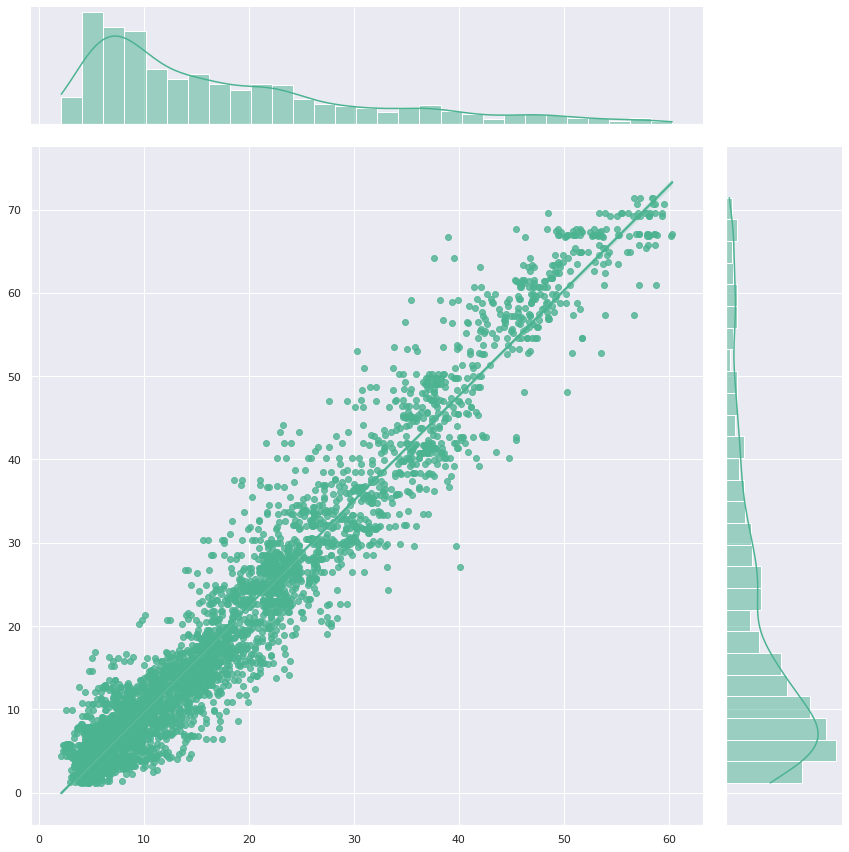

In [ ]:
model_conv6, name = create_model_conv2(inputs_shape = 4274, 
                           outputs_shape = 4, 
                           hidden_shape = ( 512, 256, 128, 64, 32, 16, 8), 
                           dropout = True,
                           kernel_siz = 6,
                           dropout_rate= 0.05,
                           max_pool_size = 2,
                           filter_size_1 = 48,
                           filter_size_2 = 48)

version = "f148_f248_b24"

loss = keras.losses.MSE
optimizer = keras.optimizers.RMSprop()


model_conv6p=model_conv6

history, dir_model_h5 = training_2(X_train_4, y_train, 
                                 batch_size = 24, 
                                 epochs = 20, 
                                 modele = model_conv6p, 
                                 name = name + '_' + version, 
                                 loss = loss,
                                 optimizer = optimizer)
# 90 epoch
model_evaluate(model_conv6p, X_test_4, y_test)

## LSTM


### Best LSTM

Epoch 1/10
114/114 [==============================] - 228s 2s/step - loss: 19.0566 - val_loss: 10.7584
Epoch 2/10
114/114 [==============================] - 219s 2s/step - loss: 17.3574 - val_loss: 10.1223
Epoch 3/10
114/114 [==============================] - 210s 2s/step - loss: 17.2459 - val_loss: 9.9173
Epoch 4/10
114/114 [==============================] - 212s 2s/step - loss: 18.5050 - val_loss: 8.4911
Epoch 5/10
114/114 [==============================] - 217s 2s/step - loss: 17.5406 - val_loss: 11.8797
Epoch 6/10
114/114 [==============================] - 211s 2s/step - loss: 17.3144 - val_loss: 8.2115
Epoch 7/10
114/114 [==============================] - 210s 2s/step - loss: 16.1309 - val_loss: 8.6068
Epoch 8/10
114/114 [==============================] - 210s 2s/step - loss: 17.4599 - val_loss: 8.4107
Epoch 9/10
114/114 [==============================] - 203s 2s/step - loss: 15.9403 - val_loss: 9.4157
Epoch 10/10
32/32 [==============================] - 17s 494ms/step
[12.9  10.6

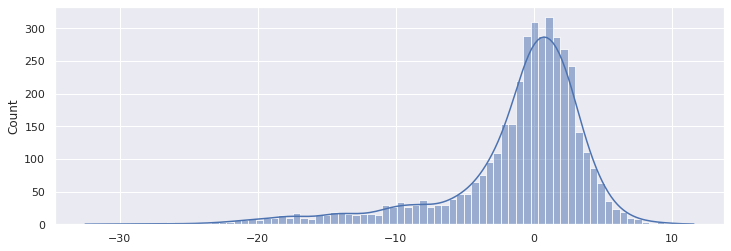

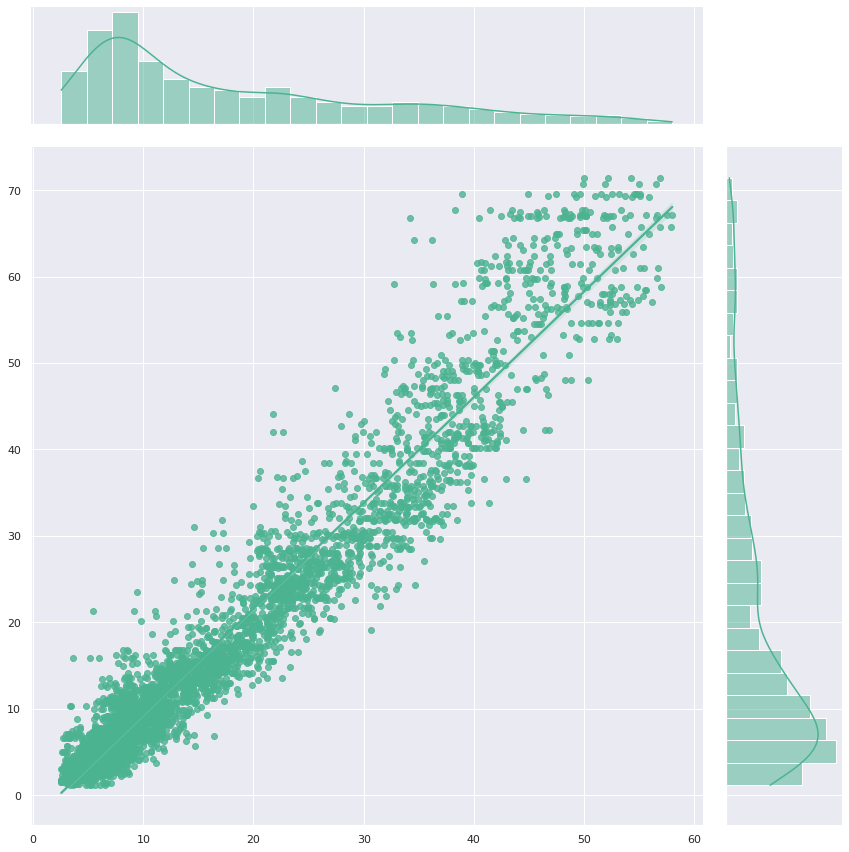

In [ ]:
def create_model_conv_lstm3(inputs_shape, outputs_shape, hidden_shape, activation ='relu', kernel_initializer = 'he_normal',kernel_siz = 6,dropout = True, dropout_rate = 0.05,max_pool_size = 2):
    
    name = 'model_EDF_' + str(hidden_shape[0]) + '_'
    name += '_conv1d_conv1d_flatten'
    for index in range(1, len(hidden_shape)):
      name = name + str(hidden_shape[index])+ '_'
    
    name = name + str(dropout) + '_dropout'

    model = keras.Sequential(name = name)

    model.add(layers.Conv1D(filters=32, kernel_size=kernel_siz, activation='relu', input_shape=(X_train_2.shape[1], X_train_2.shape[2])))
    model.add(tf.keras.layers.MaxPooling1D(2, padding="same"))
    model.add(layers.Conv1D(filters=32, kernel_size=kernel_siz, activation='relu', input_shape=(X_train_2.shape[1], X_train_2.shape[2])))
    model.add(tf.keras.layers.MaxPooling1D(2, padding="same"))

    model.add(tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True))
    model.add(tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True))

    model.add(layers.Flatten())

    for l in range(len(hidden_shape)):
      model.add(layers.Dense(units = hidden_shape[l], activation = activation, kernel_initializer = kernel_initializer))
      if dropout:
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(units = outputs_shape))

    model.summary()

    return [model, name]





model_conv_lstm3, name = create_model_conv_lstm3(inputs_shape = 4272, 
                           outputs_shape = 4, 
                           hidden_shape = (  256, 128, 64, 32, 16, 8), 
                           dropout = True,
                           kernel_siz = 12,
                           dropout_rate= 0.05,
                           max_pool_size = 2)

version = "2.2" # 80 epochs
loss = keras.losses.MSE
optimizer = keras.optimizers.RMSprop()

history, dir_model_h5 = training_2(X_train_4, y_train, 
                                 batch_size = 32, 
                                 epochs = 80, 
                                 modele = model_conv_lstm3, 
                                 name = name + '_' + version, 
                                 loss = loss,
                                 optimizer = optimizer)

model_evaluate(model_conv_lstm3, X_test_4, y_test)

# Best models Results

### Dense


Acceptable for t+1, t+2 & t+3 

Very limited for t+4

**Score Recap :**

---
> t+1 || r2 score = 0.793 || RMSE score = 31.816 || MAPE score = 22.515
---
> t+2 || r2 score = 0.771 || RMSE score = 35.189 || MAPE score = 23.889
---
> t+1 || r2 score = 0.702 || RMSE score = 43.378 || MAPE score = 26.906
---
> t+1 || r2 score = 0.614 || RMSE score = 53.763 || MAPE score = 31.119
---



In [19]:
# model3 = keras.models.load_model('/content/gdrive/MyDrive/Deep Learning/Models/model_Dense.h5')
model3 = keras.models.load_model('Models/model_Dense.h5')
pred3 = model3.predict(X_test_4)

32/32 [==============================] - 1s 13ms/step


[12.9  10.61  6.83 ...  3.93  3.78  3.69]
[10.239719  10.198141  10.140436  ...  4.389311   5.179115   5.0152426]
Variance Score = 0.8672080203922578
Moyenne des biais = -1.86182977977651
r2 score = 0.8549559261849914
RMSE score = 41.03643329037277
Mean Absolute Percentage Error = 32.86322357367691


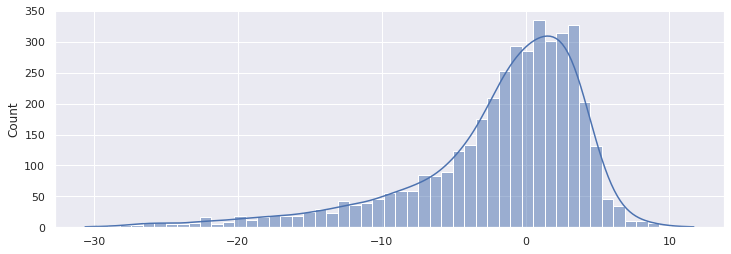

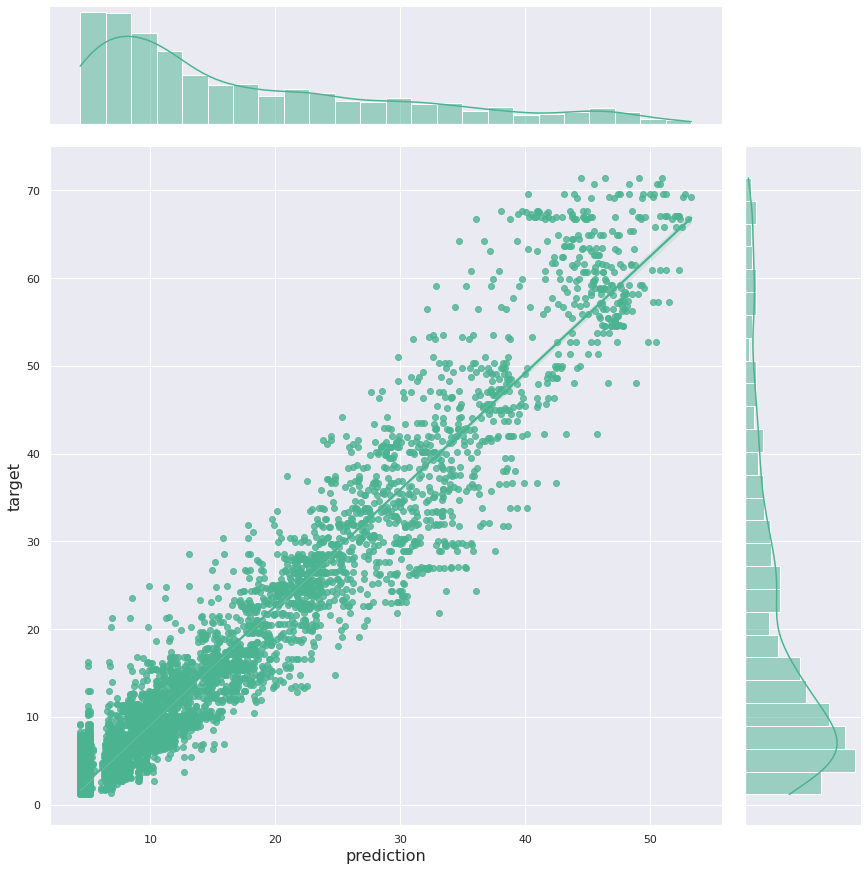

In [20]:
model_evaluateb(model3,pred3,test)

Wind Load Factor at t + 1
[12.9  10.61  6.83 ...  3.7   4.01  4.27]
[10.239719   9.936762   9.299117  ...  4.6496844  4.6496844  4.6496844]
Variance Score = 0.8976575955975163
Moyenne des biais = -1.6991363872780383
r2 score = 0.8874440392242863
RMSE score = 31.816176709804676
Mean Absolute Percentage Error = 29.733417765783543



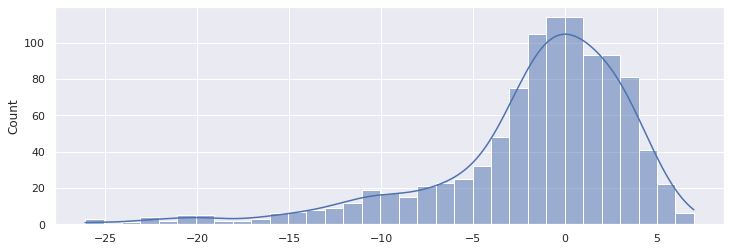

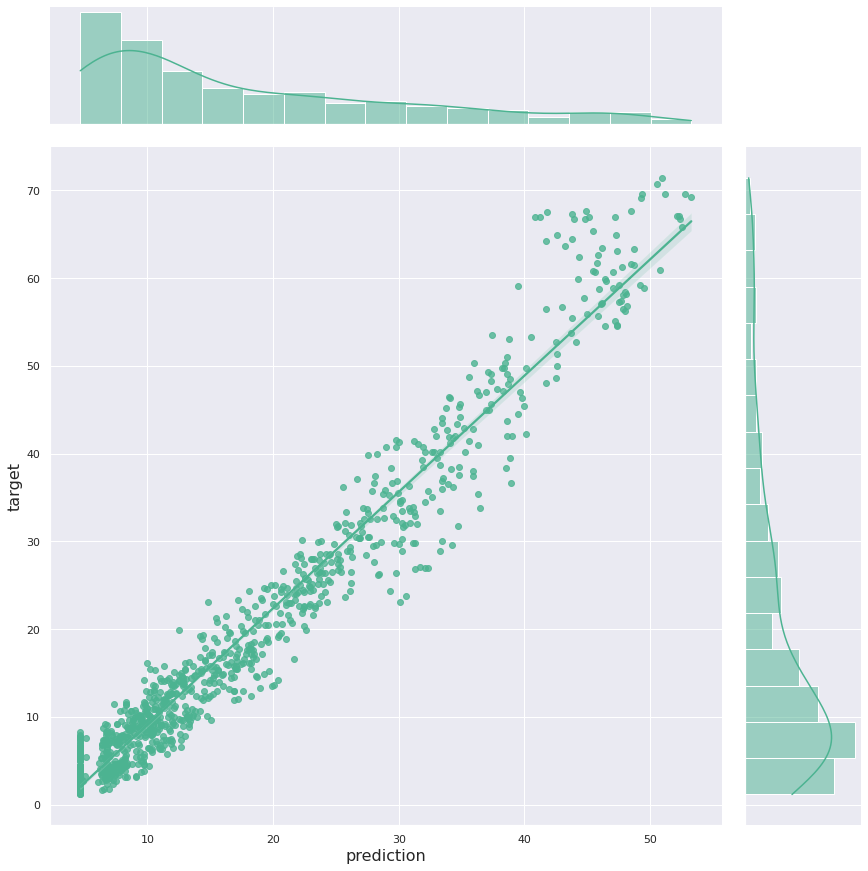

In [ ]:
i=0

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model3,pred3[:,i],test[:,i])
print()

Wind Load Factor at t + 2
[10.61  6.83  4.2  ...  4.01  4.27  3.93]
[10.198141  9.896486  9.261576 ...  4.389311  4.389311  4.389311]
Variance Score = 0.886992007217055
Moyenne des biais = -1.7951274788791551
r2 score = 0.8755998141951811
RMSE score = 35.1887860012741
Mean Absolute Percentage Error = 29.720886855456936



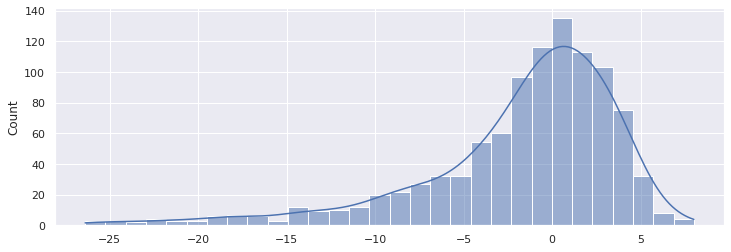

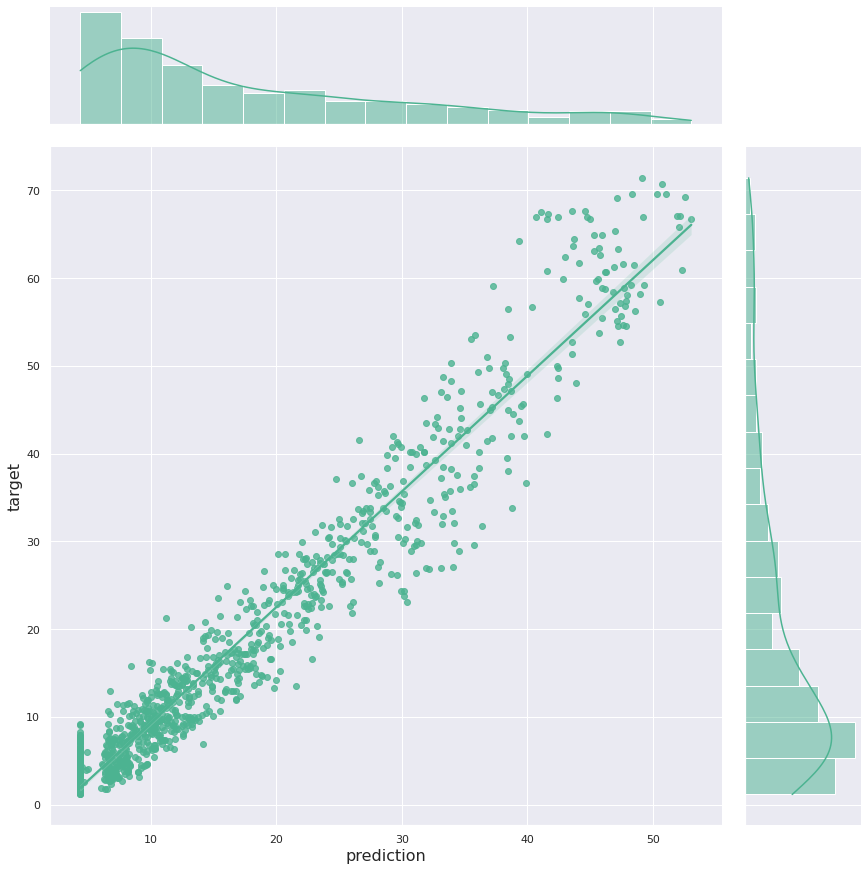

In [ ]:
i=1

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model3,pred3[:,i],test[:,i])
print()

Wind Load Factor at t + 3
[6.83 4.2  4.09 ... 4.27 3.93 3.78]
[10.140436  9.84428   9.220989 ...  5.179115  5.179115  5.179115]
Variance Score = 0.8593819741048324
Moyenne des biais = -1.8915381920184695
r2 score = 0.846740703174809
RMSE score = 43.37767978077996
Mean Absolute Percentage Error = 34.16655316337647



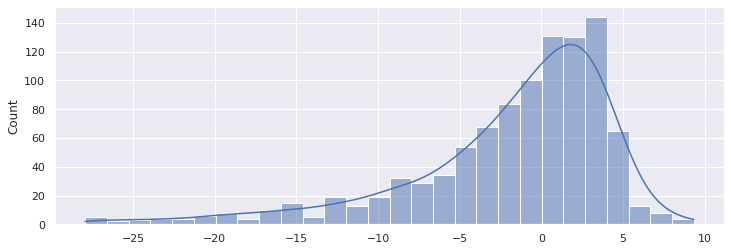

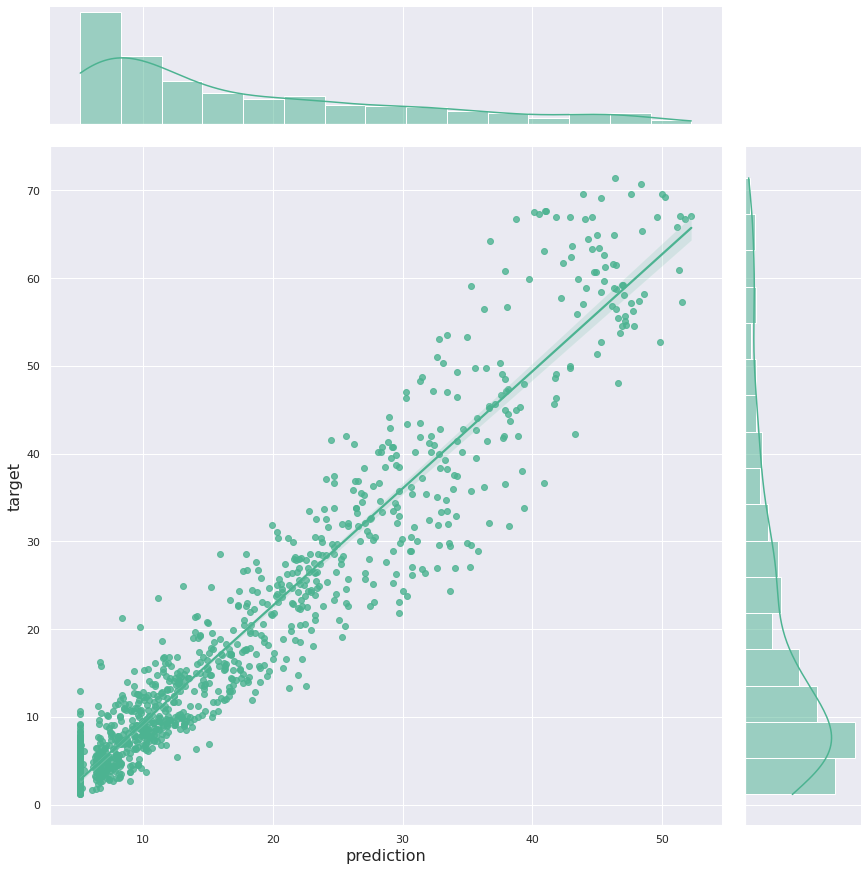

In [ ]:
i=2

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model3,pred3[:,i],test[:,i])
print()

Wind Load Factor at t + 4
[4.2  4.09 4.5  ... 3.93 3.78 3.69]
[10.207662   9.919184   9.312113  ...  5.0152426  5.0152426  5.0152426]
Variance Score = 0.8251177487485433
Moyenne des biais = -2.0615170609303783
r2 score = 0.8101071411266632
RMSE score = 53.763090669632334
Mean Absolute Percentage Error = 37.8320365100907



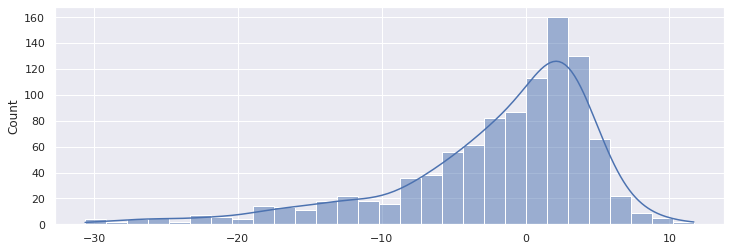

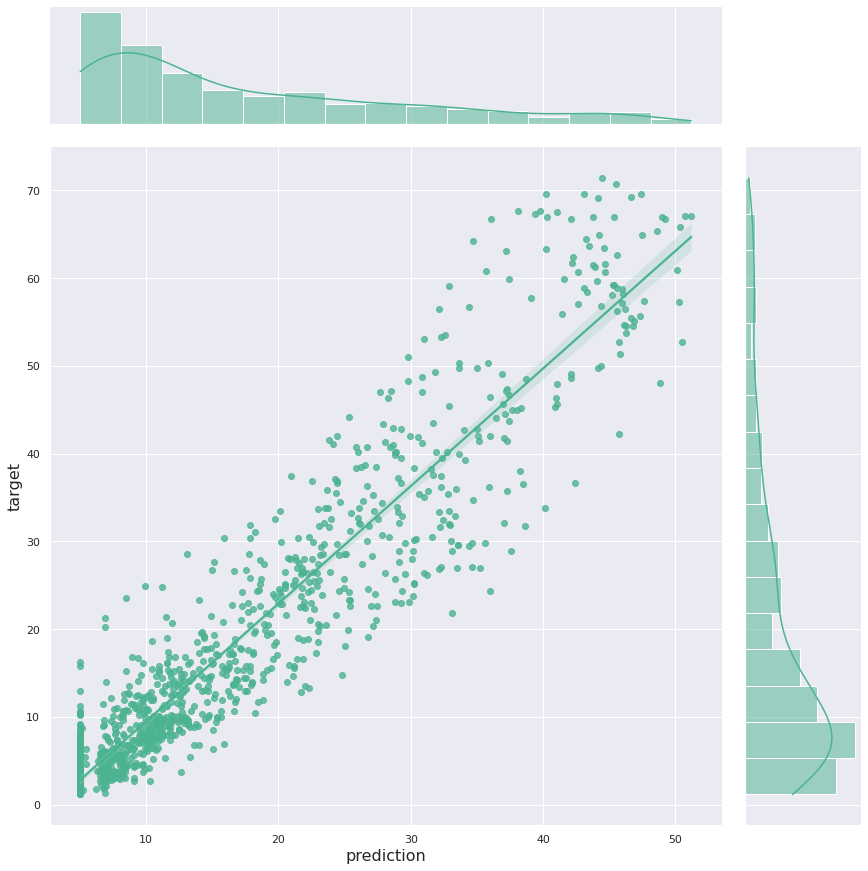

In [ ]:
i=3

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model3,pred3[:,i],test[:,i])
print()

### Conv + Dense



Good for t+1, t+2 & t+3 

Acceptable for t+4

**Score Recap :**

---
> t+1 || r2 score = 0.871 || RMSE score = 22.516 || MAPE score = 20.320
---
> t+2 || r2 score = 0.861 || RMSE score = 24.248 || MAPE score = 21.853
---
> t+1 || r2 score = 0.824 || RMSE score = 30.181 || MAPE score = 25.076
---
> t+1 || r2 score = 0.768 || RMSE score = 38.656 || MAPE score = 28.381
---













In [21]:
# model1 = keras.models.load_model('/content/gdrive/MyDrive/Deep Learning/Models/model_Conv_Dense.h5')
model1 = keras.models.load_model('Models/model_Conv_Dense.h5')
pred1 = model1.predict(X_test_4)

32/32 [==============================] - 4s 137ms/step


[12.9  10.61  6.83 ...  3.93  3.78  3.69]
[12.79689   13.078204  13.4518585 ...  5.963508   6.4177923  6.9036126]
Variance Score = 0.9050642886684541
Moyenne des biais = -1.4284892634342827
r2 score = 0.897851813290687
RMSE score = 28.900162132618735
Mean Absolute Percentage Error = 31.06760270140266


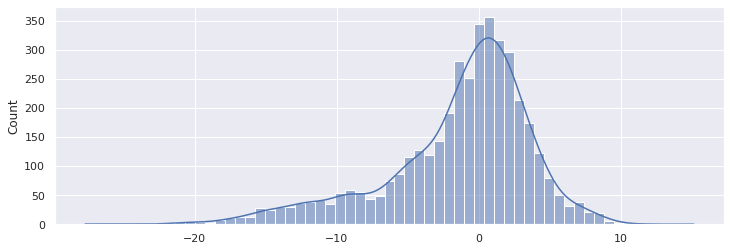

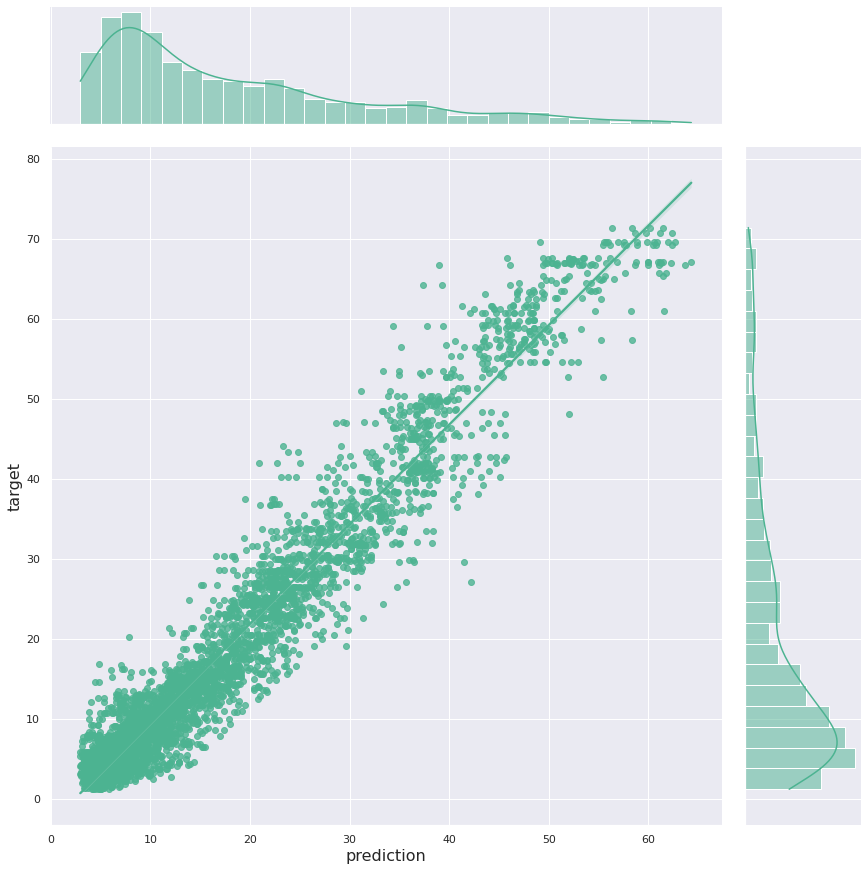

In [22]:
model_evaluateb(model1,pred1,test)

Wind Load Factor at t + 1
[12.9  10.61  6.83 ...  3.7   4.01  4.27]
[12.79689   10.176051   8.489629  ...  6.013464   6.1981173  5.655303 ]
Variance Score = 0.9344532165423959
Moyenne des biais = -1.9970869280861256
r2 score = 0.9203436248113208
RMSE score = 22.516455739875482
Mean Absolute Percentage Error = 24.19280573088235



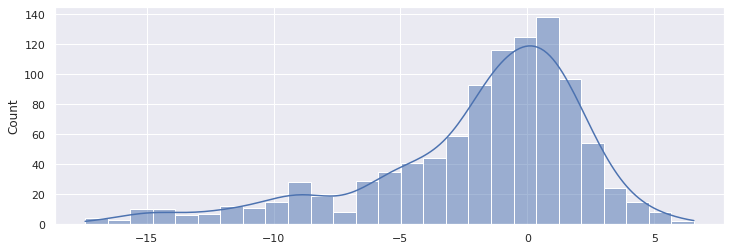

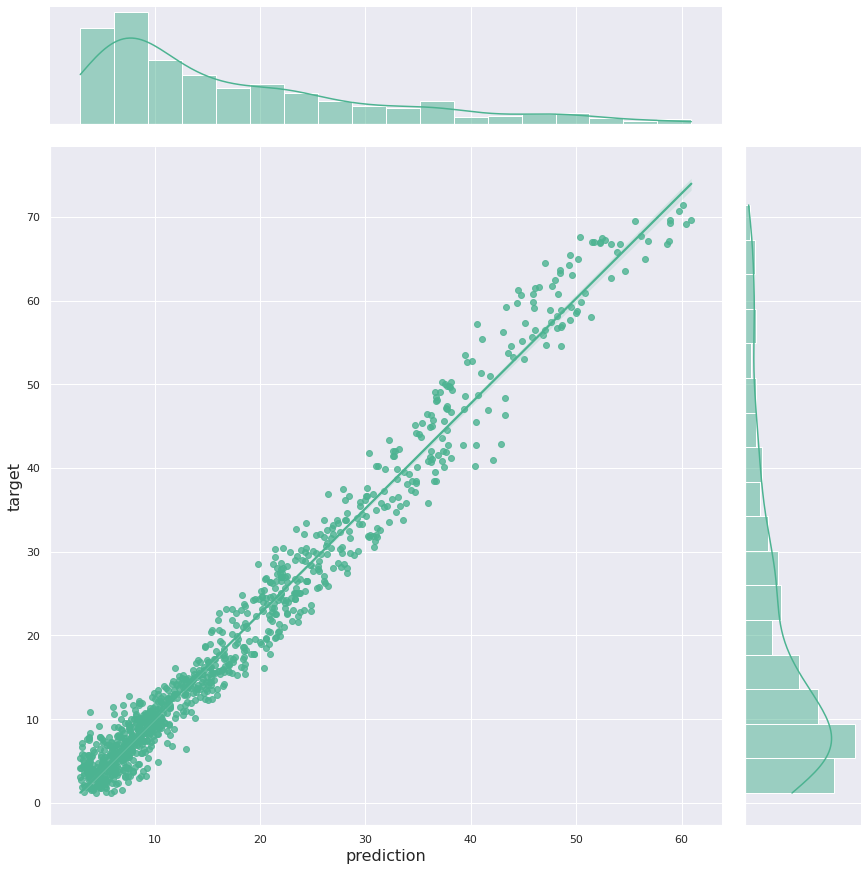

In [ ]:
i=0

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model1,pred1[:,i],test[:,i])
print()

Wind Load Factor at t + 2
[10.61  6.83  4.2  ...  4.01  4.27  3.93]
[13.078204 10.909126  9.487207 ...  6.38415   6.380023  5.963508]
Variance Score = 0.9239035237943217
Moyenne des biais = -1.6499916050111672
r2 score = 0.9142789786470649
RMSE score = 24.247702338095973
Mean Absolute Percentage Error = 27.171678772518455



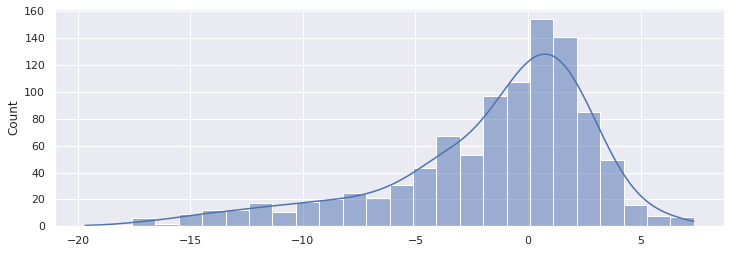

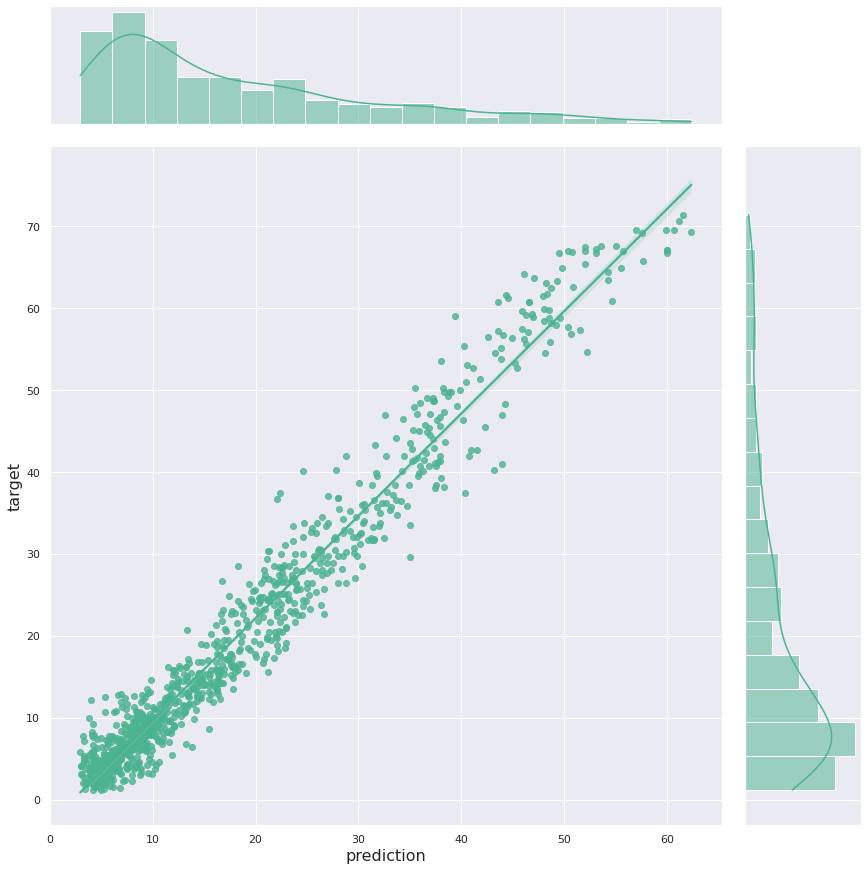

In [ ]:
i=1

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model1,pred1[:,i],test[:,i])
print()

Wind Load Factor at t + 3
[6.83 4.2  4.09 ... 4.27 3.93 3.78]
[13.4518585 11.832049  10.741969  ...  6.911395   6.6840105  6.4177923]
Variance Score = 0.8986442294303342
Moyenne des biais = -1.2222076649962386
r2 score = 0.8933664587483681
RMSE score = 30.18097891692524
Mean Absolute Percentage Error = 33.155507910898685



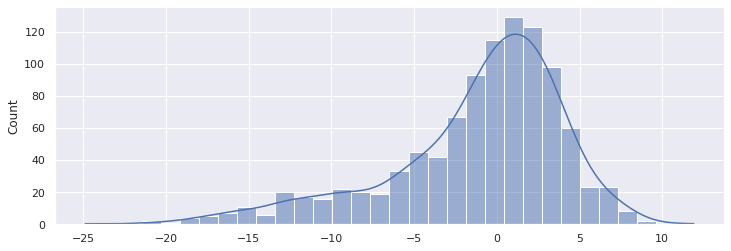

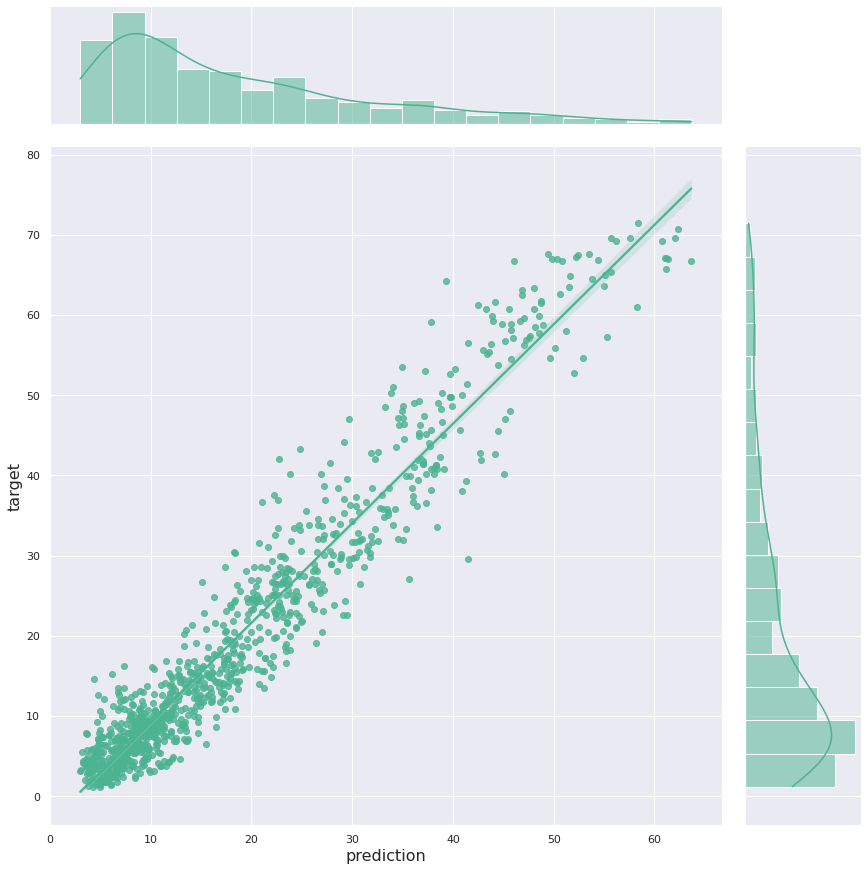

In [ ]:
i=2

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model1,pred1[:,i],test[:,i])
print()

Wind Load Factor at t + 4
[4.2  4.09 4.5  ... 3.93 3.78 3.69]
[13.798513  12.654261  11.860565  ...  7.45229    7.0461063  6.9036126]
Variance Score = 0.8659875601181212
Moyenne des biais = -0.8446708556436012
r2 score = 0.8634675665912119
RMSE score = 38.65551153557827
Mean Absolute Percentage Error = 39.75041839131116



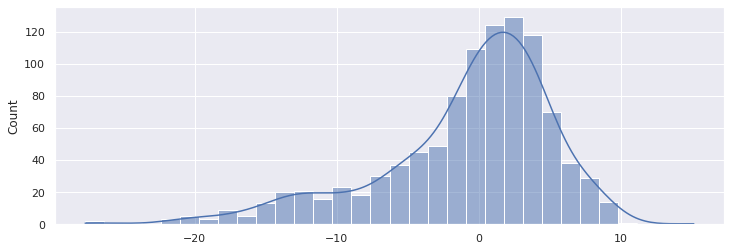

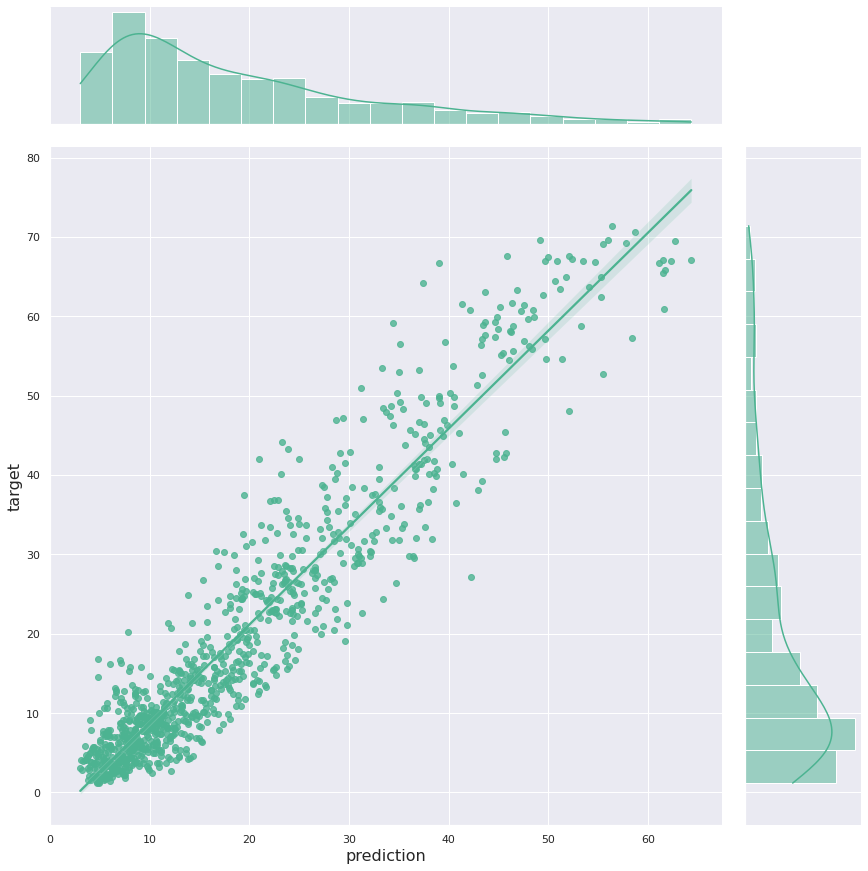

In [ ]:
i=3

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model1,pred1[:,i],test[:,i])
print()

### Conv + LSTM + Dense

Quite good for t+1 

Good for t+2 & t+3 

Limited for t+4

**Score Recap :**

---
> t+1 || r2 score = 0.919 || RMSE score = 16.062 || MAPE score = 15.792
---
> t+2 || r2 score = 0.882 || RMSE score = 21.927 || MAPE score = 18.582
---
> t+1 || r2 score = 0.801 || RMSE score = 33.534 || MAPE score = 23.415
---
> t+1 || r2 score = 0.688 || RMSE score = 47.295 || MAPE score = 28.590
---


In [23]:
# model = keras.models.load_model('/content/gdrive/MyDrive/Deep Learning/Models/model_Conv_LSTM_Dense.h5')
model = keras.models.load_model('Models/model_Conv_LSTM_Dense.h5')
pred = model.predict(X_test_4)

32/32 [==============================] - 15s 425ms/step


[12.9  10.61  6.83 ...  3.93  3.78  3.69]
[13.001575  12.191751  11.492464  ...  4.9949656  5.1439333  5.2807655]
Variance Score = 0.9004141566326764
Moyenne des biais = -1.2366599250734147
r2 score = 0.8950087178015136
RMSE score = 29.70454176227825
Mean Absolute Percentage Error = 26.231564836202896


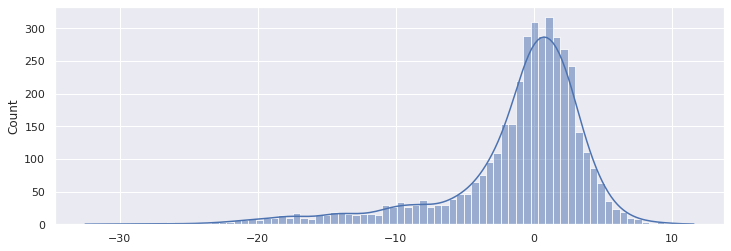

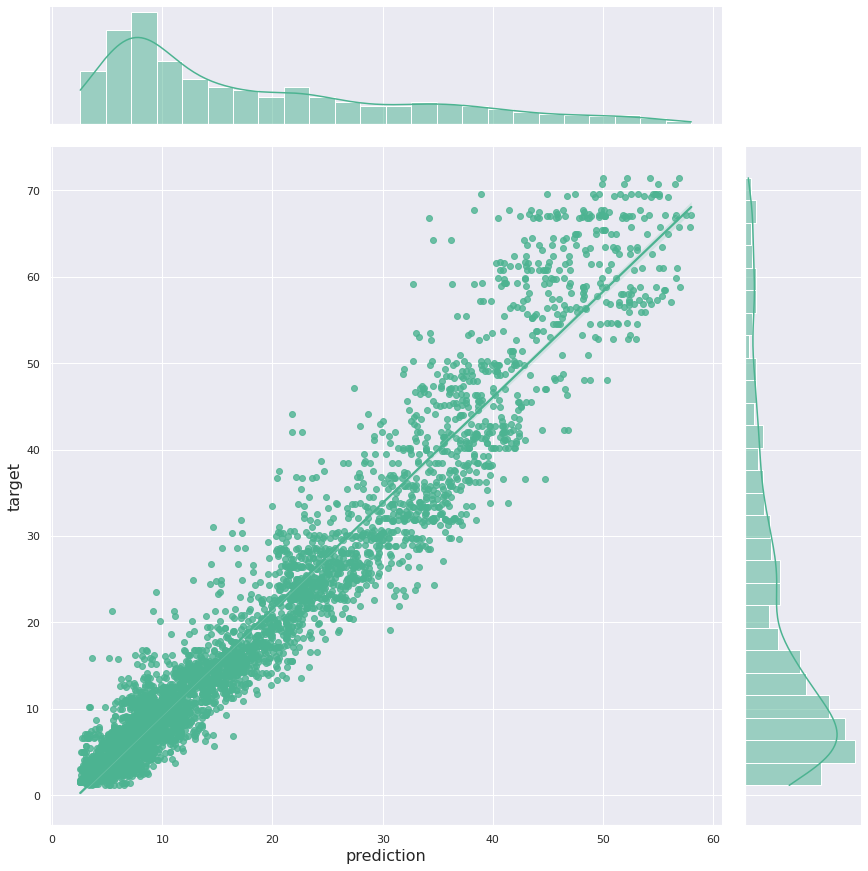

In [24]:
model_evaluateb(model,pred,test)

Wind Load Factor at t + 1
[12.9  10.61  6.83 ...  3.7   4.01  4.27]
[13.001575  11.444935   9.6923485 ...  4.871731   5.768014   5.128272 ]
Variance Score = 0.9443777840373087
Moyenne des biais = -0.5828281735856115
r2 score = 0.9431760687563577
RMSE score = 16.06241220219418
Mean Absolute Percentage Error = 21.58341053337183



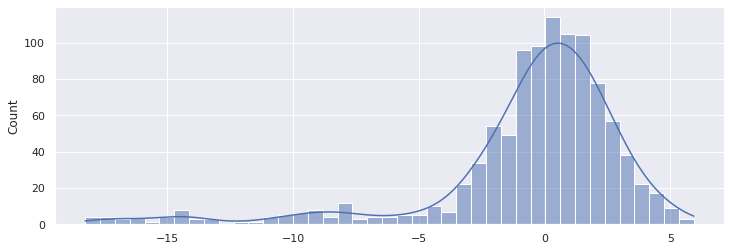

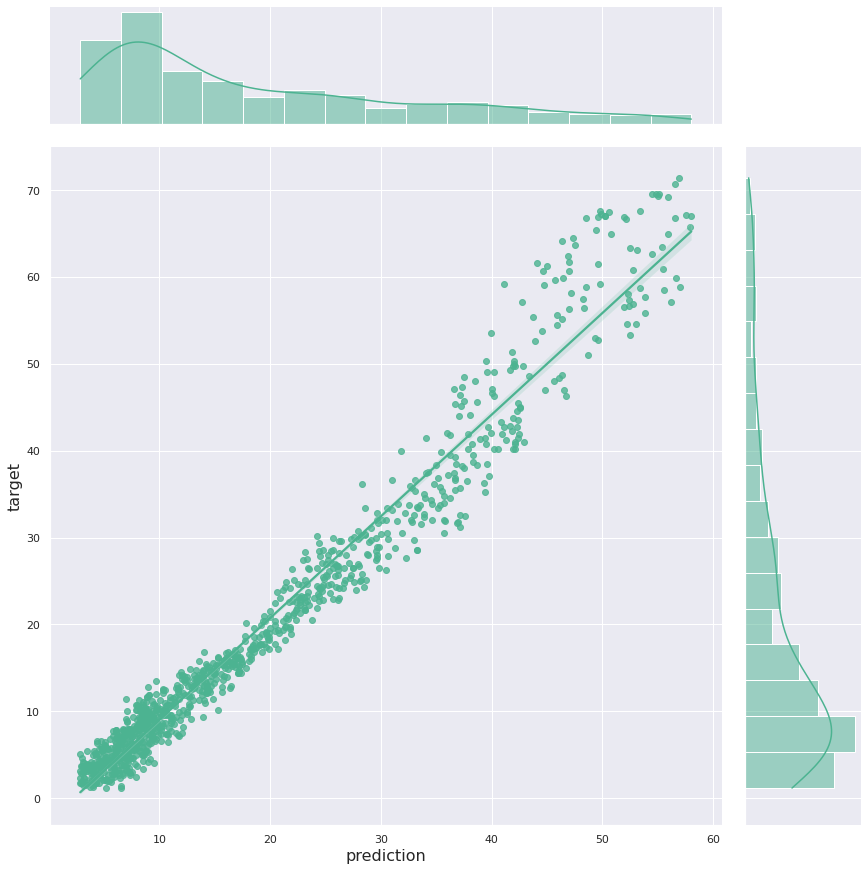

In [ ]:
i=0

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model,pred[:,i],test[:,i])
print()

Wind Load Factor at t + 2
[10.61  6.83  4.2  ...  4.01  4.27  3.93]
[12.191751  10.718652   9.093499  ...  4.817188   5.6891274  4.9949656]
Variance Score = 0.9262705409710046
Moyenne des biais = -1.0348928614688886
r2 score = 0.9224843063054549
RMSE score = 21.926680732111887
Mean Absolute Percentage Error = 23.18321358892987



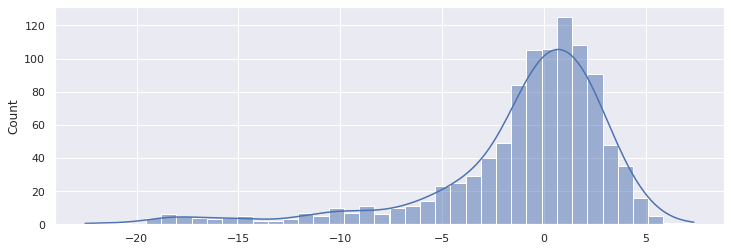

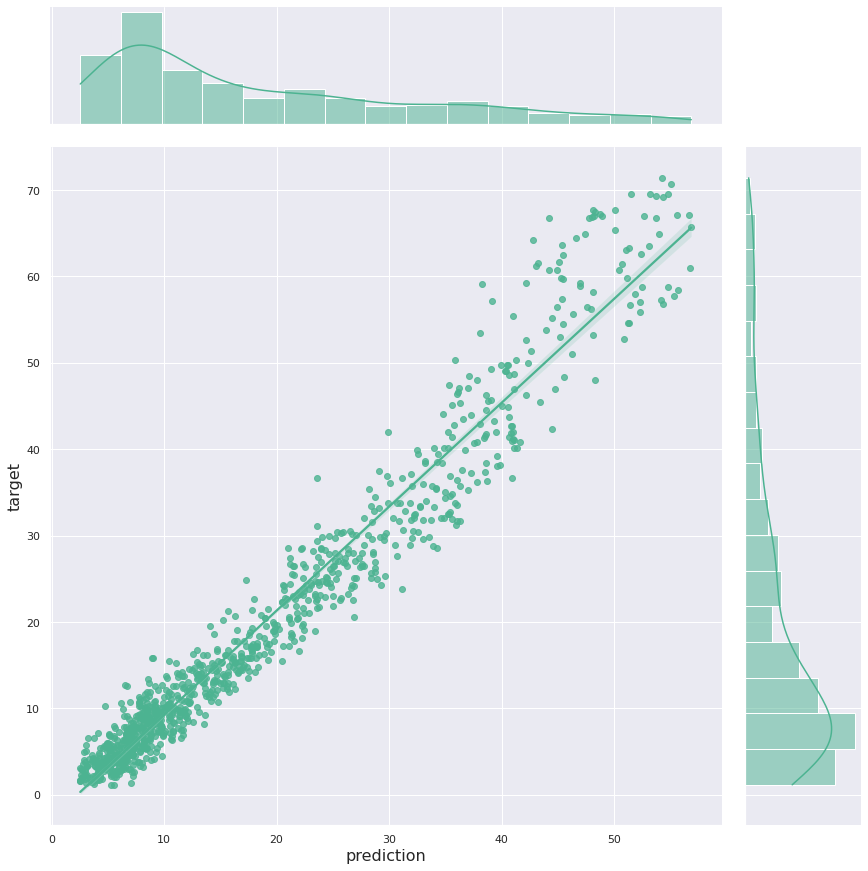

In [ ]:
i=1

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model,pred[:,i],test[:,i])
print()

Wind Load Factor at t + 3
[6.83 4.2  4.09 ... 4.27 3.93 3.78]
[11.492464  10.13272    8.671218  ...  5.0560575  5.886327   5.1439333]
Variance Score = 0.8889160038684786
Moyenne des biais = -1.4468674176301797
r2 score = 0.8815196448477947
RMSE score = 33.534036841937876
Mean Absolute Percentage Error = 27.68959526485722



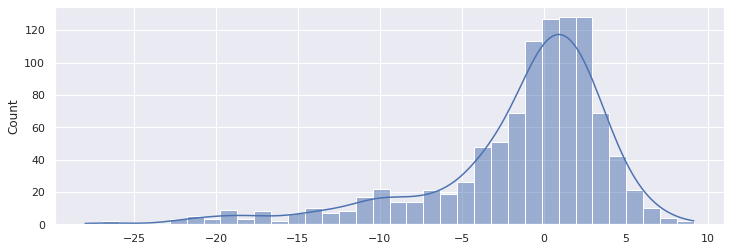

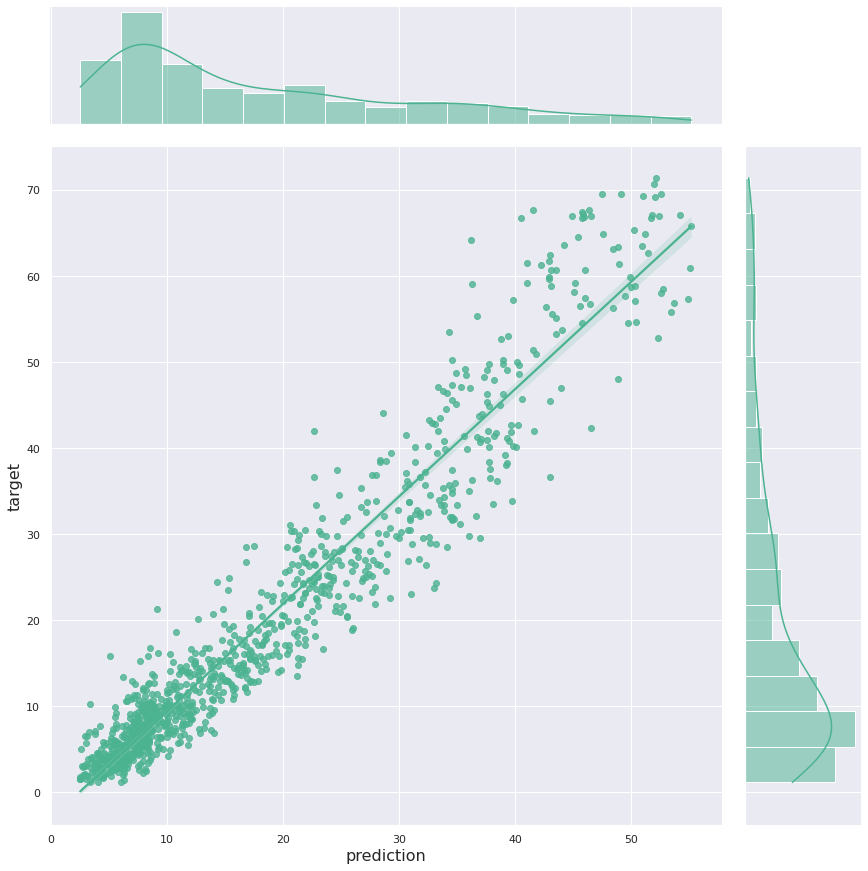

In [ ]:
i=2

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model,pred[:,i],test[:,i])
print()

Wind Load Factor at t + 4
[4.2  4.09 4.5  ... 3.93 3.78 3.69]
[10.844055   9.592391   8.284092  ...  5.2733774  6.0626974  5.2807655]
Variance Score = 0.8454633647277405
Moyenne des biais = -1.8820512476089797
r2 score = 0.8329525009368746
RMSE score = 47.29503727286908
Mean Absolute Percentage Error = 32.47003995765267



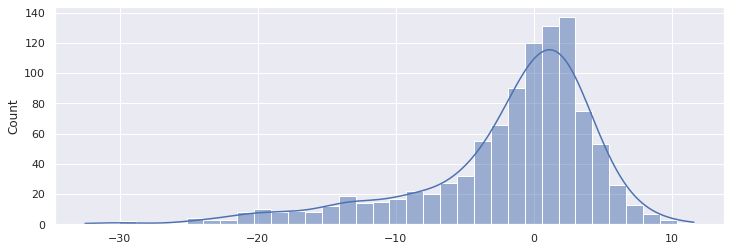

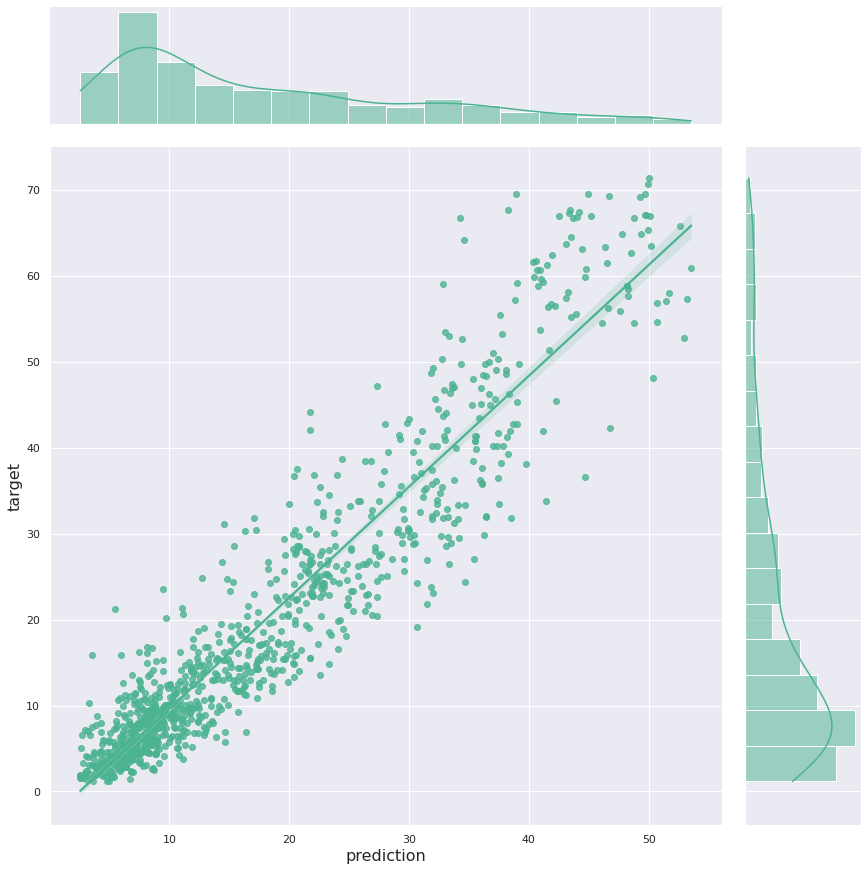

In [ ]:
i=3

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model,pred[:,i],test[:,i])
print()

# Combination of the best model for each time step ahead


[12.9  10.61  6.83 ...  3.93  3.78  3.69]
[13.001575  12.191751  11.492464  ...  4.9949656  5.1439333  6.9036126]
Variance Score = 0.9060188369114138
Moyenne des biais = -0.9773148270820698
r2 score = 0.9026428608561698
RMSE score = 27.544660327955548
Mean Absolute Percentage Error = 28.051659444617517


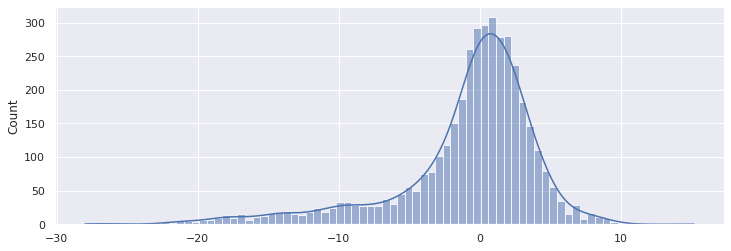

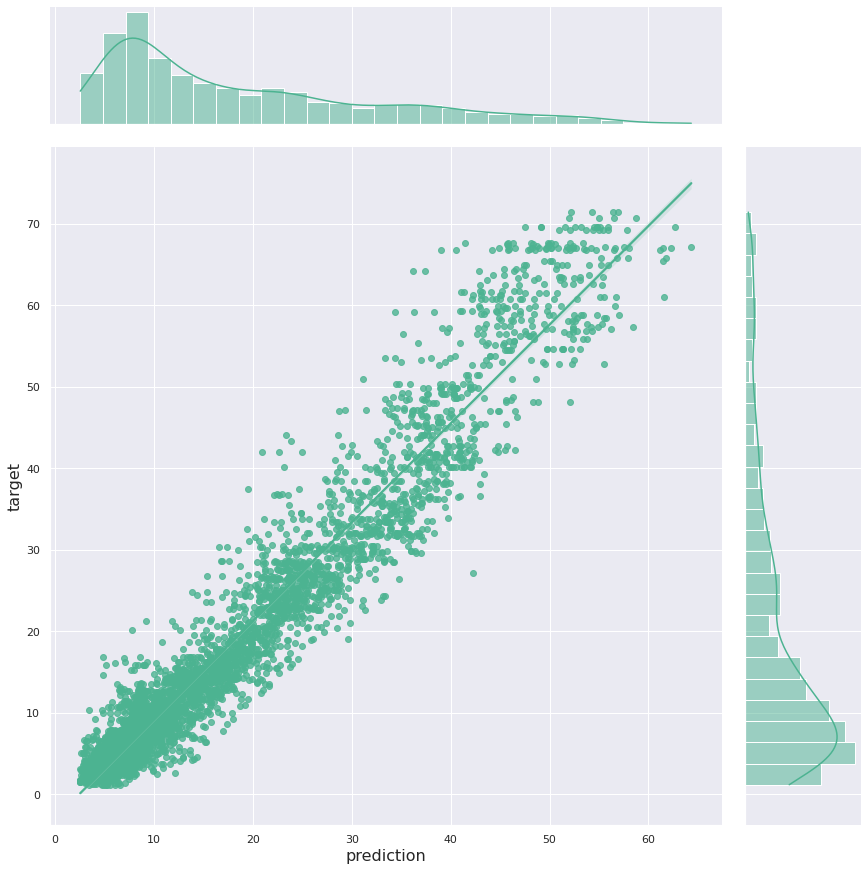

In [ ]:
tamp = np.concatenate((pred[:,:3],pred1[:,3:]), axis = 1)
model_evaluateb(model,tamp,test)

Wind Load Factor at t + 1
[12.9  10.61  6.83 ...  3.7   4.01  4.27]
[13.001575  11.444935   9.6923485 ...  4.871731   5.768014   5.128272 ]
Variance Score = 0.9443777840373087
Moyenne des biais = -0.5828281735856115
r2 score = 0.9431760687563577
RMSE score = 16.06241220219418
Mean Absolute Percentage Error = 21.58341053337183



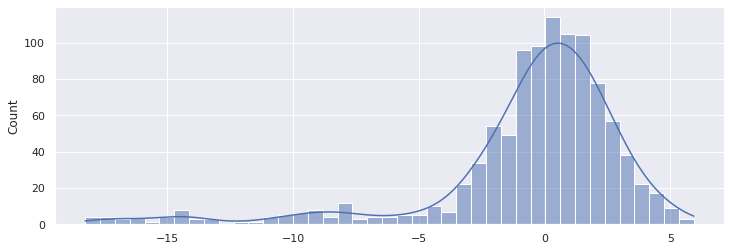

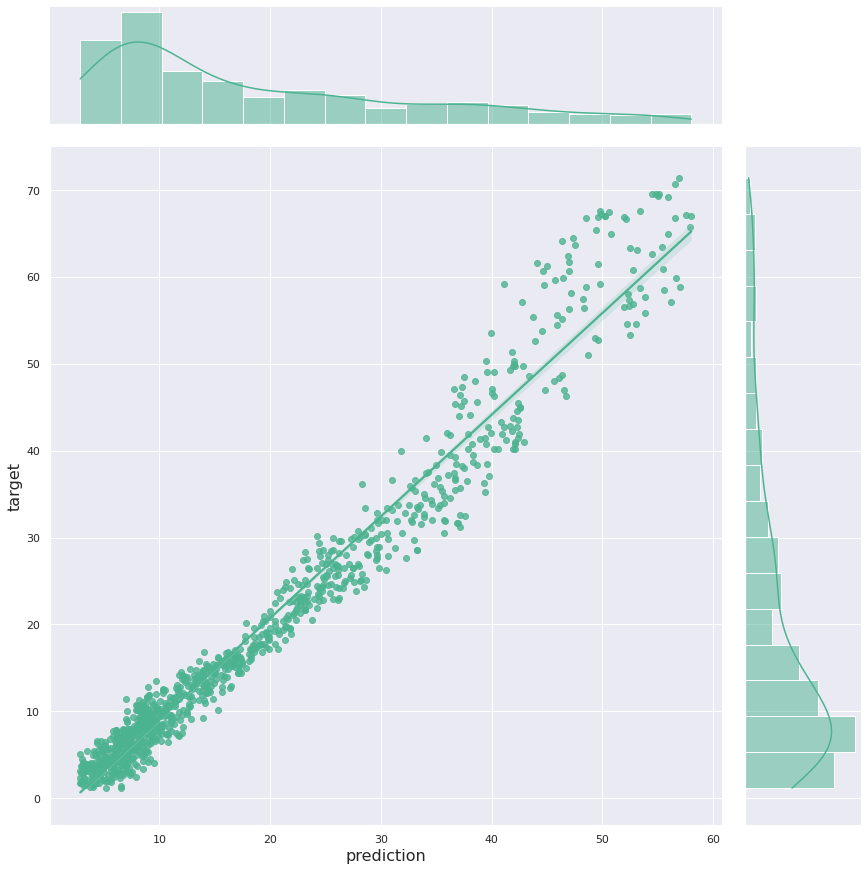

In [ ]:
i=0

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model,tamp[:,i],test[:,i])
print()

Wind Load Factor at t + 2
[10.61  6.83  4.2  ...  4.01  4.27  3.93]
[12.191751  10.718652   9.093499  ...  4.817188   5.6891274  4.9949656]
Variance Score = 0.9262705409710046
Moyenne des biais = -1.0348928614688886
r2 score = 0.9224843063054549
RMSE score = 21.926680732111887
Mean Absolute Percentage Error = 23.18321358892987



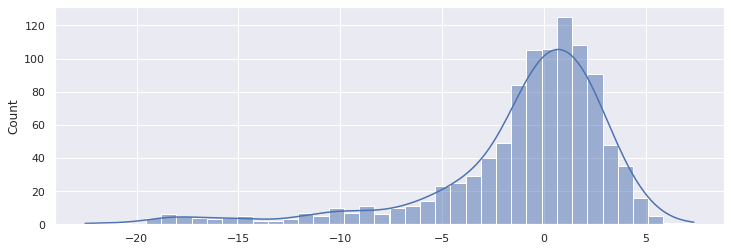

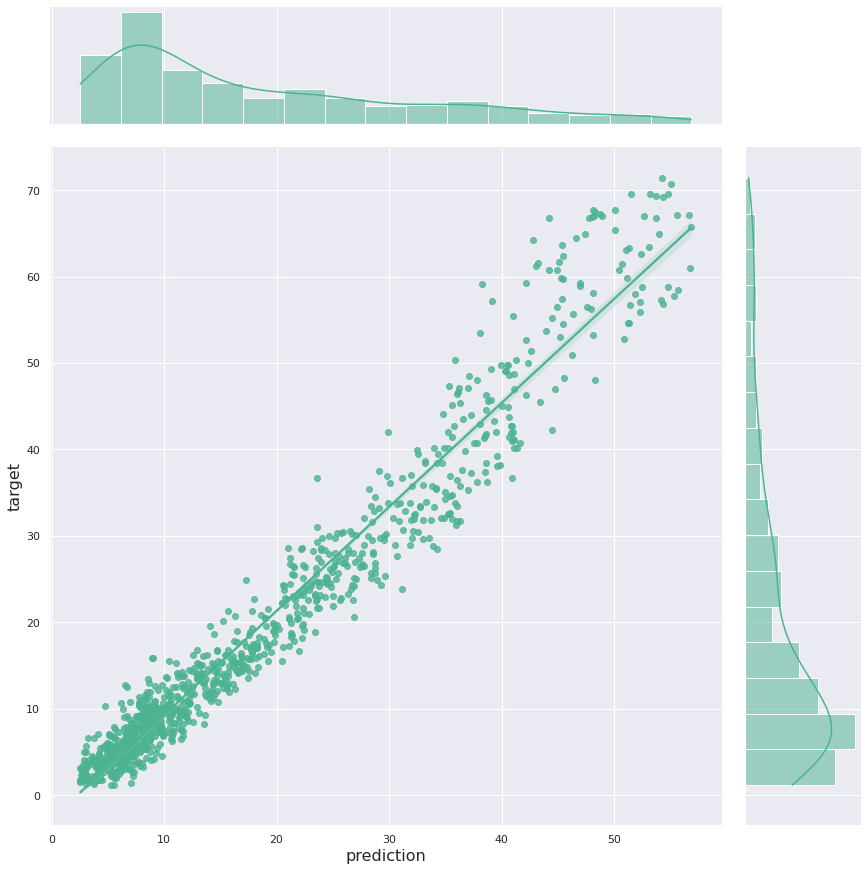

In [ ]:
i=1

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model,tamp[:,i],test[:,i])
print()

Wind Load Factor at t + 3
[6.83 4.2  4.09 ... 4.27 3.93 3.78]
[11.492464  10.13272    8.671218  ...  5.0560575  5.886327   5.1439333]
Variance Score = 0.8889160038684786
Moyenne des biais = -1.4468674176301797
r2 score = 0.8815196448477947
RMSE score = 33.534036841937876
Mean Absolute Percentage Error = 27.68959526485722



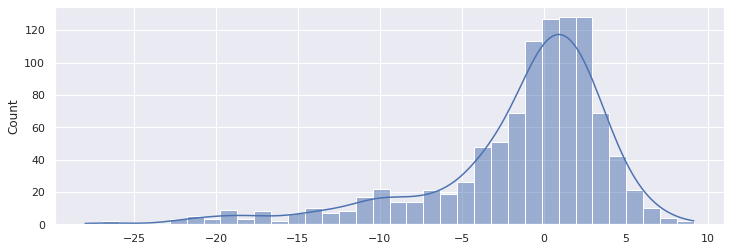

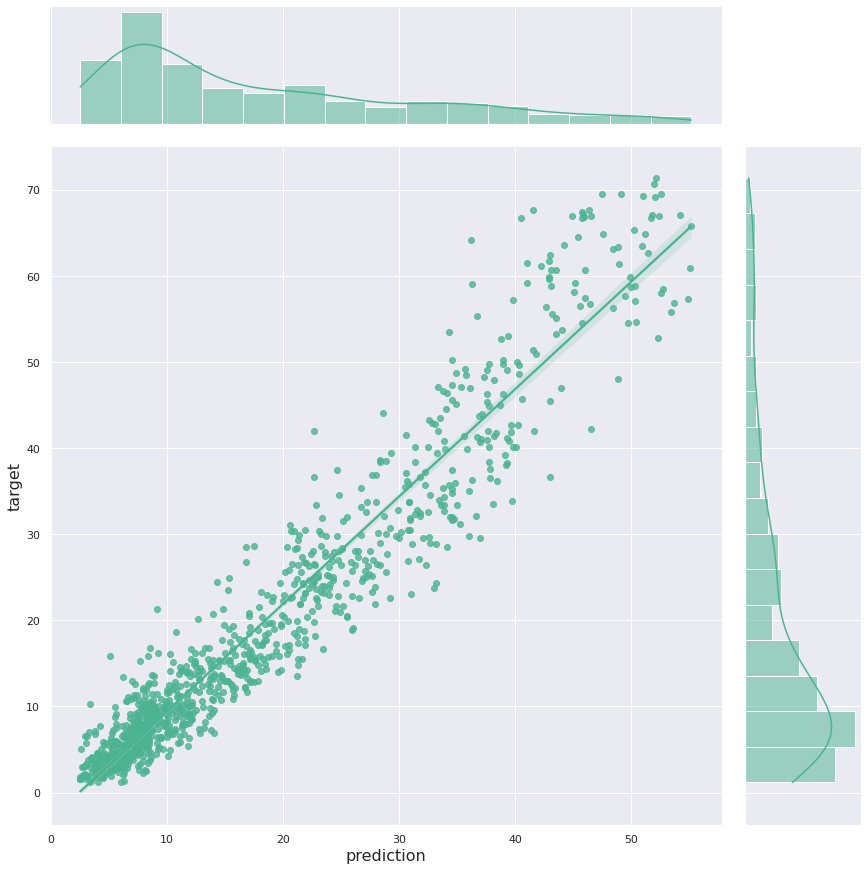

In [ ]:
i=2

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model,tamp[:,i],test[:,i])
print()

Wind Load Factor at t + 4
[4.2  4.09 4.5  ... 3.93 3.78 3.69]
[13.798513  12.654261  11.860565  ...  7.45229    7.0461063  6.9036126]
Variance Score = 0.8659875601181212
Moyenne des biais = -0.8446708556436012
r2 score = 0.8634675665912119
RMSE score = 38.65551153557827
Mean Absolute Percentage Error = 39.75041839131116



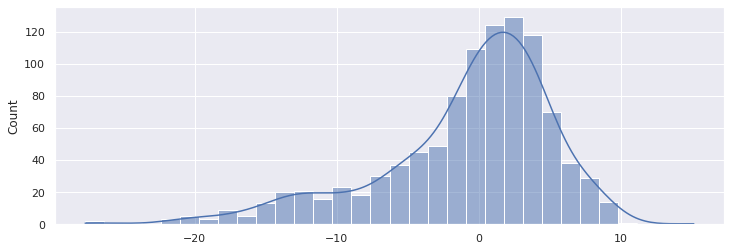

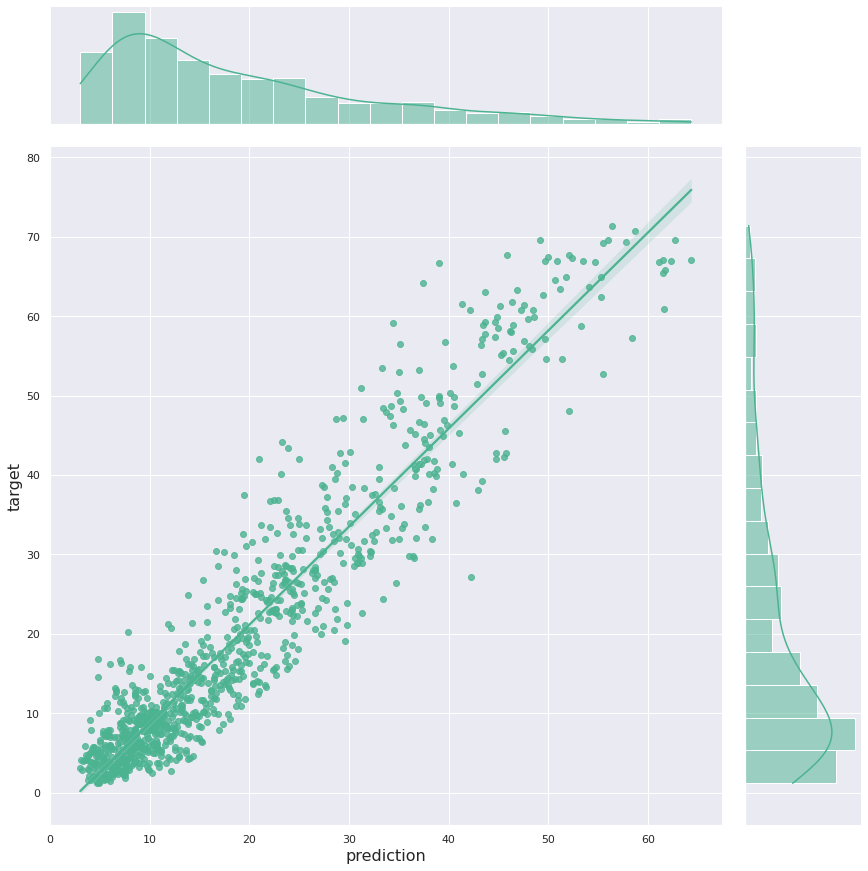

In [ ]:
i=3

print('Wind Load Factor at t + ' + str(i+1))
model_evaluateb(model,tamp[:,i],test[:,i])
print()

In [ ]:
np.shape(test)

(1013, 4)

[12.9  10.61  6.83 ...  3.93  3.78  3.69]
[13.001575  12.191751  13.4518585 ...  4.9949656  6.4177923  6.9036126]
Variance Score = 0.9086048233162343
Moyenne des biais = -0.9211498889235846
r2 score = 0.905605723014171
RMSE score = 26.706395846702392
Mean Absolute Percentage Error = 29.418137606127885


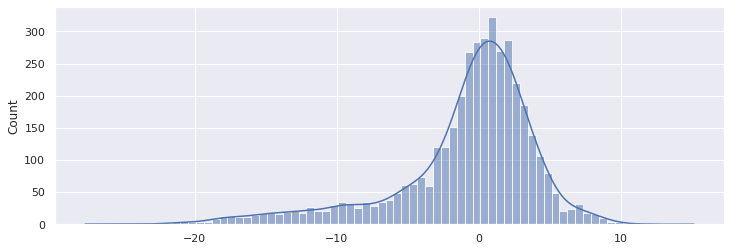

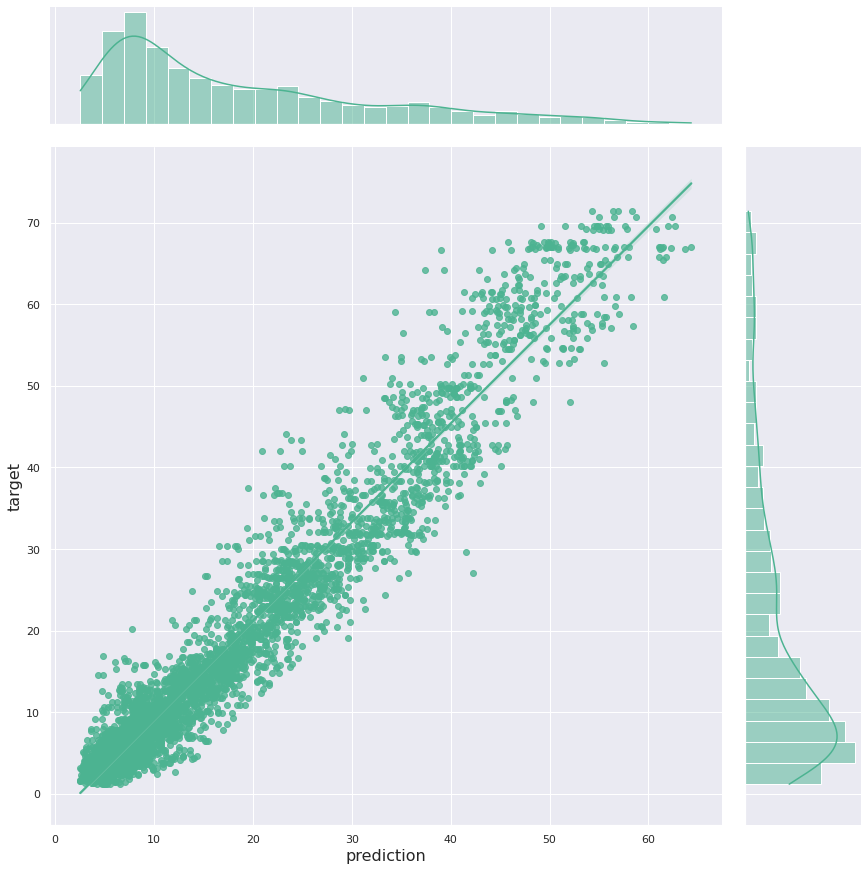

In [ ]:
tamp = np.concatenate((pred[:,:2],pred1[:,2:]), axis = 1)
model_evaluateb(model,tamp,test)

[12.9  10.61  6.83 ...  3.93  3.78  3.69]
[13.001575  12.191751  11.492464  ...  4.9949656  5.1439333  5.2807655]
Variance Score = 0.9004141566326764
Moyenne des biais = -1.2366599250734147
r2 score = 0.8950087178015136
RMSE score = 29.70454176227825
Mean Absolute Percentage Error = 26.231564836202896


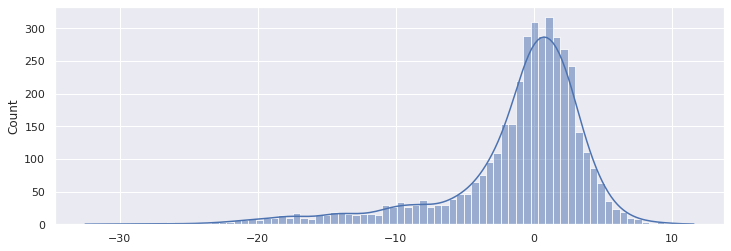

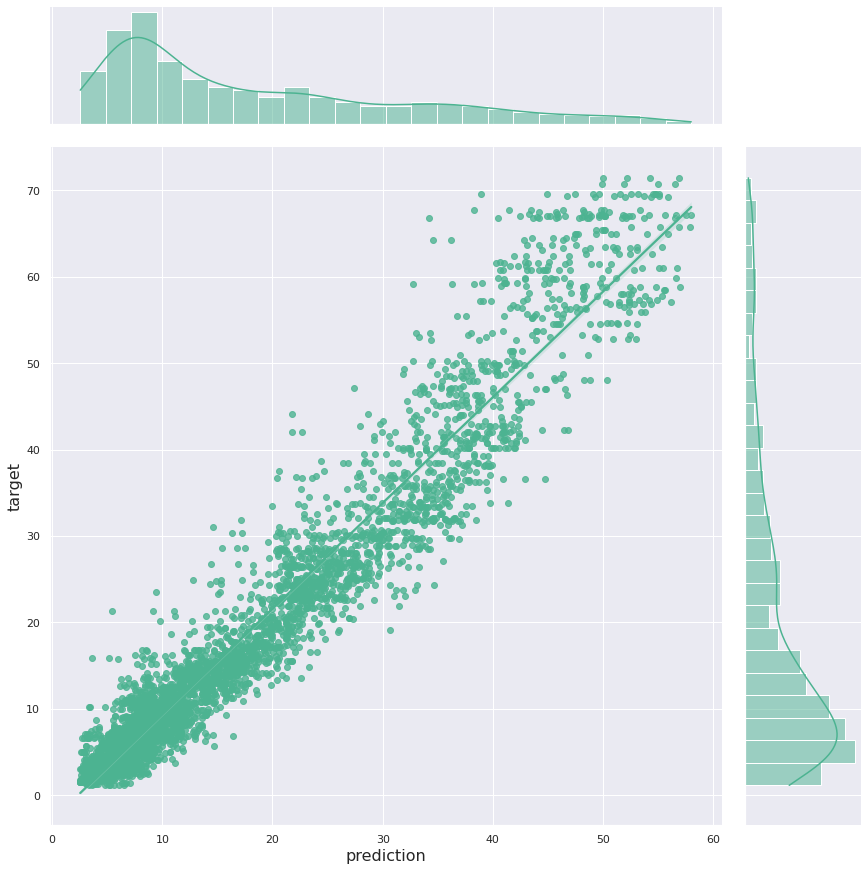

In [ ]:
# r2 score = 0.8950087178015136
# RMSE score = 29.70454176227825
# Mean Absolute Percentage Error = 26.231564836202896
model_evaluateb(model,pred,test)

# Few Graphs about the data
<!-- https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ -->


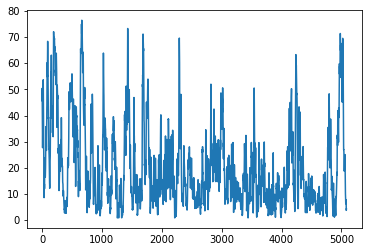

In [ ]:
ytilde = pd.DataFrame.to_numpy(y) 
X

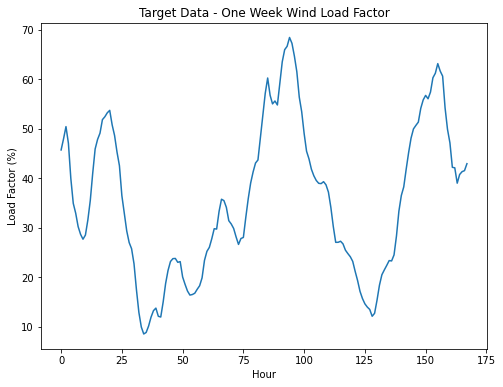

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(ytilde[:168,0])
plt.title("Target Data - One Week Wind Load Factor")
plt.ylabel("Load Factor (%)")
plt.xlabel('Hour')
plt.savefig("lf.png")

In [ ]:
import matplotlib.pyplot as plt
Xtilde=pd.DataFrame.to_numpy(X)

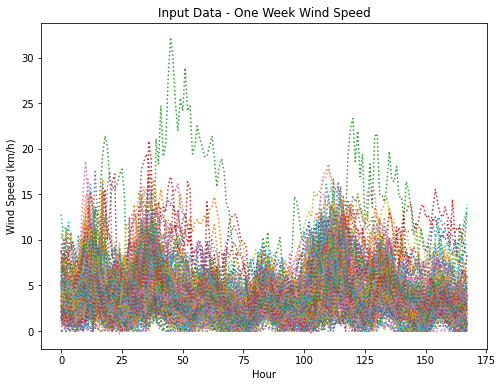

In [ ]:
tampon2 = Xtilde[:168,:175]
tampon2 = np.transpose(tampon2)

plt.figure(figsize=(8, 6))

for i in range(168):

  plt.plot(tampon2[i], linestyle=':')
plt.title("Input Data - One Week Wind Speed")
plt.ylabel("Wind Speed (km/h)")
plt.xlabel('Hour')
plt.savefig("wind.png")

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

plt.show()

array([[6.944     , 7.778     , 2.26892554, ..., 3.056     , 5.278     ,
        5.        ],
       [6.111     , 7.5       , 2.35015448, ..., 3.056     , 5.        ,
        4.444     ],
       [6.944     , 8.333     , 2.59551954, ..., 3.889     , 7.222     ,
        3.889     ],
       ...,
       [2.778     , 3.056     , 1.59466131, ..., 3.056     , 3.056     ,
        1.944     ],
       [3.333     , 3.611     , 1.49375171, ..., 3.333     , 2.778     ,
        1.667     ],
       [4.167     , 3.611     , 1.54460413, ..., 3.056     , 2.5       ,
        1.667     ]])

In [ ]:
np.transpose(tampon2)

array([[6.944     , 6.111     , 6.944     , ..., 2.778     , 3.333     ,
        4.167     ],
       [7.778     , 7.5       , 8.333     , ..., 3.056     , 3.611     ,
        3.611     ],
       [2.26892554, 2.35015448, 2.59551954, ..., 1.59466131, 1.49375171,
        1.54460413],
       ...,
       [3.056     , 3.056     , 3.889     , ..., 3.056     , 3.333     ,
        3.056     ],
       [5.278     , 5.        , 7.222     , ..., 3.056     , 2.778     ,
        2.5       ],
       [5.        , 4.444     , 3.889     , ..., 1.944     , 1.667     ,
        1.667     ]])

In [ ]:
X2=pd.DataFrame.to_numpy(X)

In [ ]:
X2=pd.DataFrame.to_numpy(X)

np.shape(X2)
X2 = X2.reshape([np.shape(X2)[0],np.shape(X2)[1],1])
np.shape(X2)

np.hstack((X2,tamp))

(5085, 4272, 1)

In [ ]:
ajouter les 24 derniers facteurs de charge